In [1]:
!pip install catboost lightgbm optuna xgboost

In [2]:
!pip install shap openpyxl missingno statsmodels

In [3]:
!pip install fastapi uvicorn pyngrok nest_asyncio

Importing required libraries

In [4]:
# Basic libraries
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Model building
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# Hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

# Model interpretation
import shap

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Phase 1: Project Setup and Data Understanding



Load and Understand the Data

In [5]:
# Loading the dataset
file_path = '/content/Stragetic.Data 2006-2022.xlsx'
df = pd.read_excel(file_path)

# Basic information about the dataset
print(df.info())

# The first few rows of the dataset
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company_Name           51000 non-null  object 
 1   City                   51000 non-null  object 
 2   Year                   51000 non-null  int64  
 3   Revenue                51000 non-null  int64  
 4   Expenses               51000 non-null  float64
 5   Assets                 51000 non-null  float64
 6   Liabilities            51000 non-null  float64
 7   Equity                 51000 non-null  float64
 8   Environmental_Score    51000 non-null  int64  
 9   Social_Score           51000 non-null  int64  
 10  Governance_Score       51000 non-null  int64  
 11  Profit_Loss            51000 non-null  float64
 12  Sector                 51000 non-null  object 
 13  Company_Size           51000 non-null  object 
 14  Revenue_North China    51000 non-null  float64
 15  Re

Phase 2: Data Preparation, Feature Engineering and
Handle Missing Values:
For stkcd, year, industry, name, ESG, E, S, and G columns, we can impute missing values with the mean (for numerical columns and for categorical columns)
Plotting density plots of all the columns we have

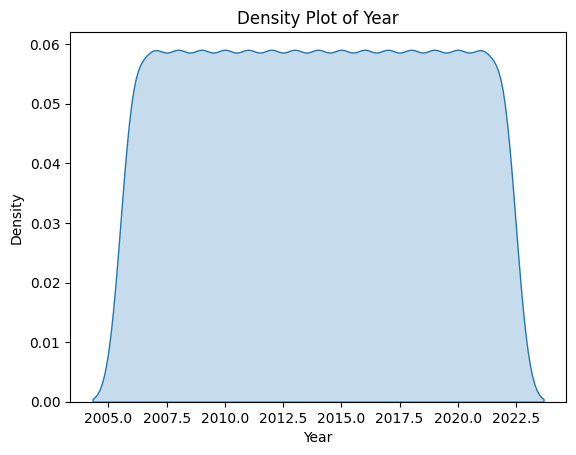

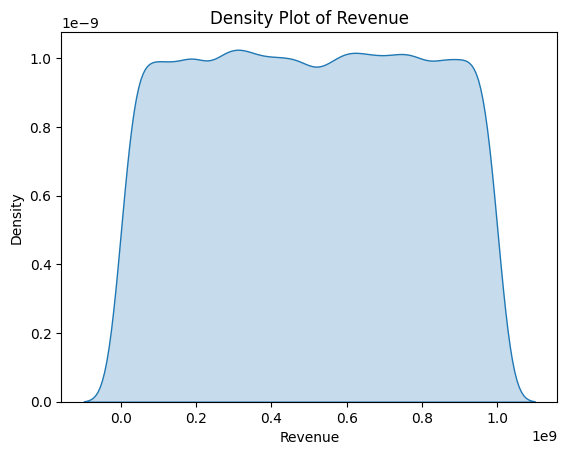

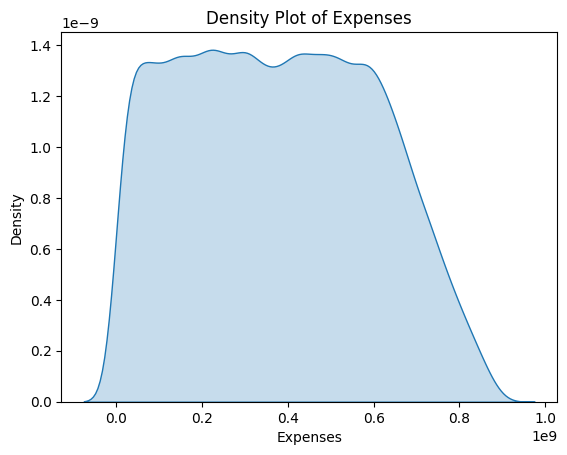

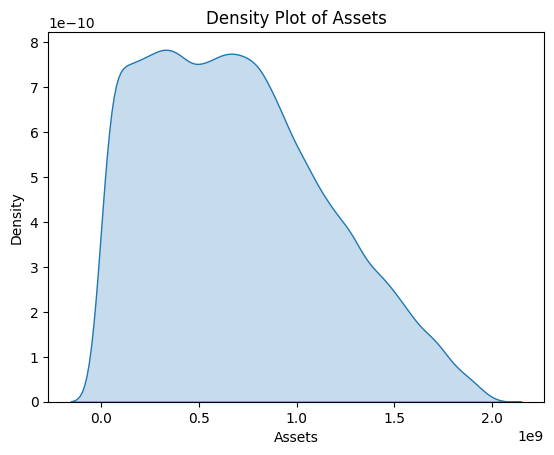

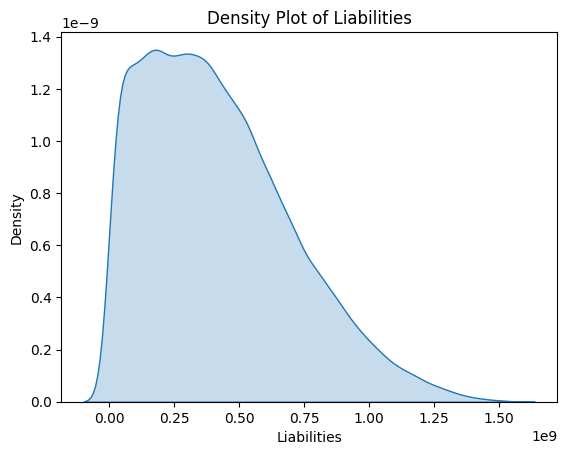

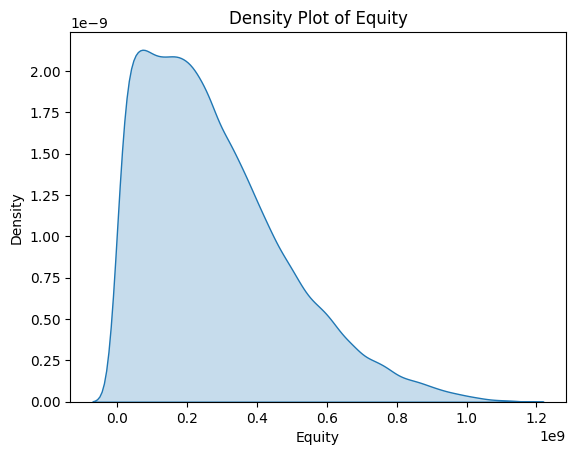

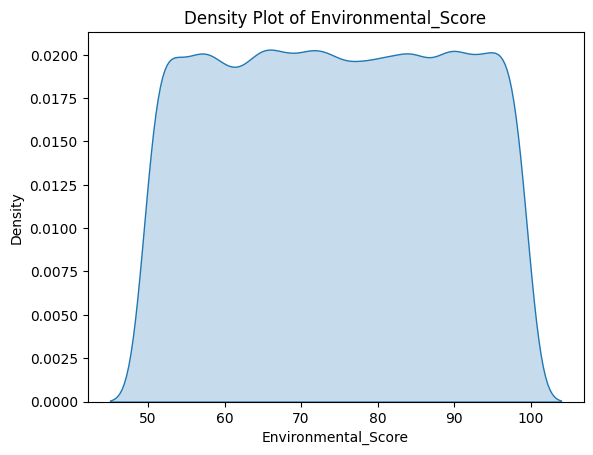

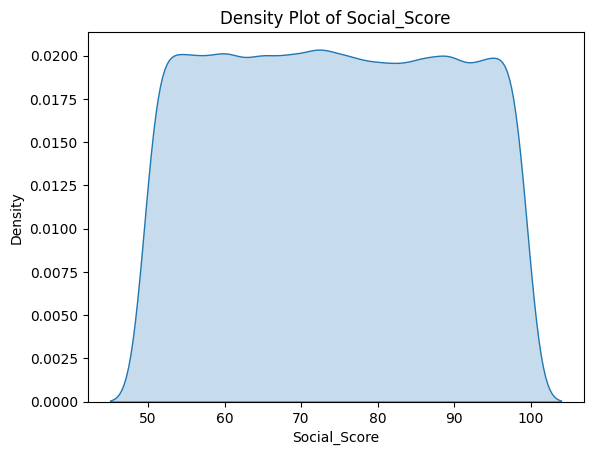

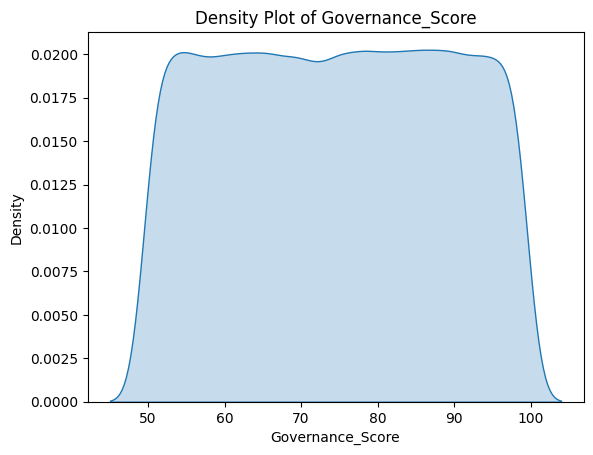

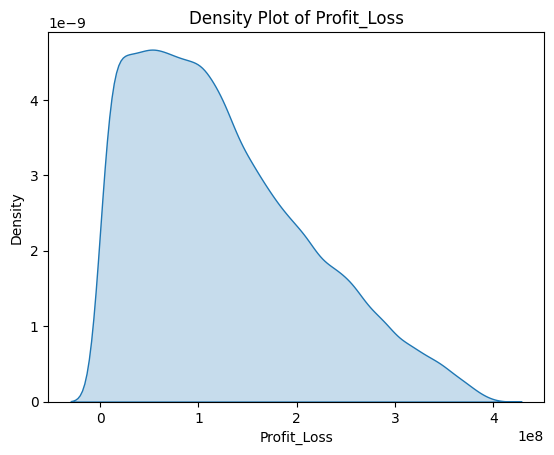

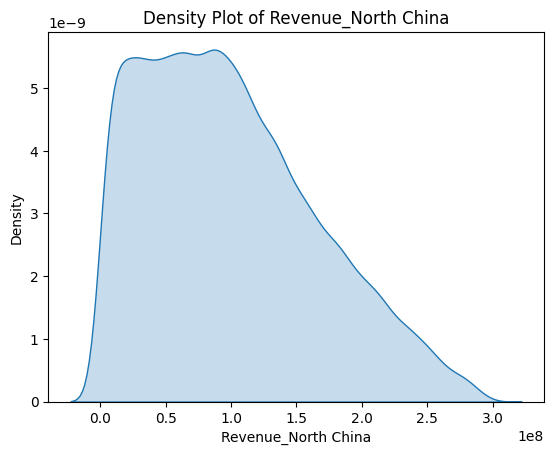

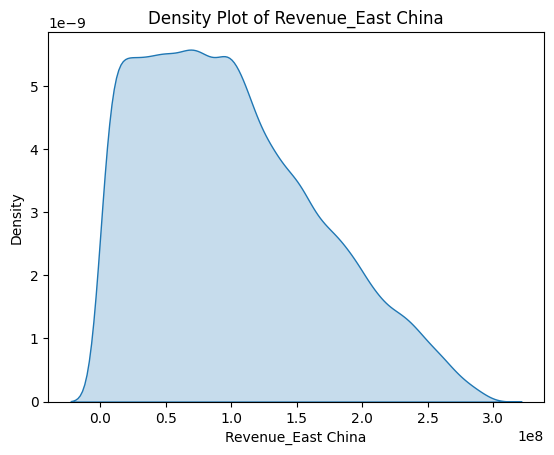

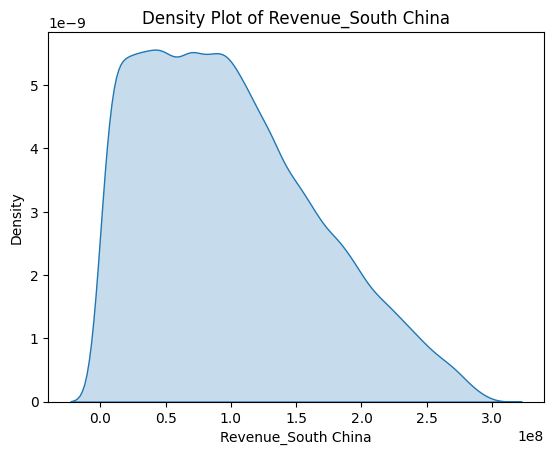

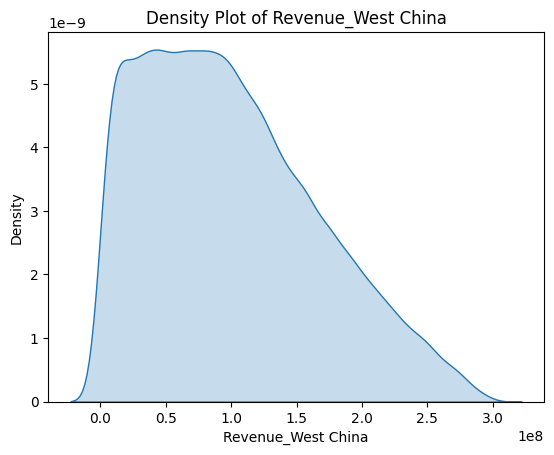

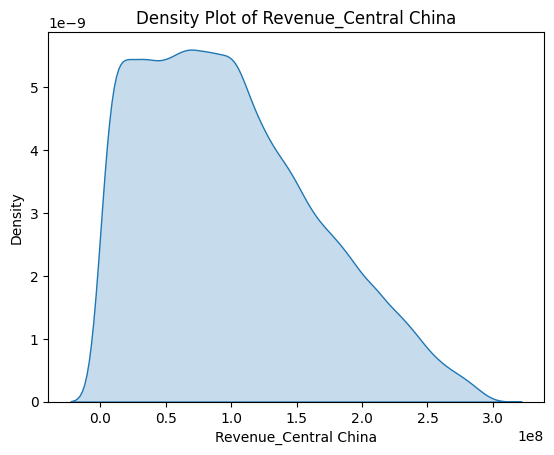

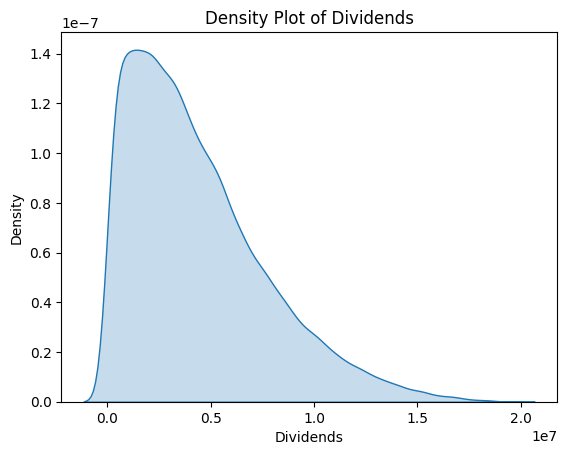

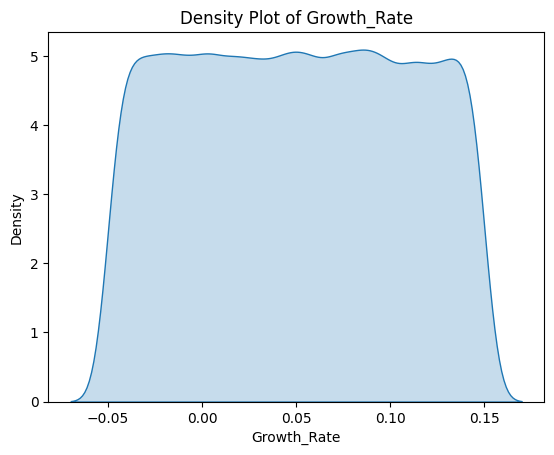

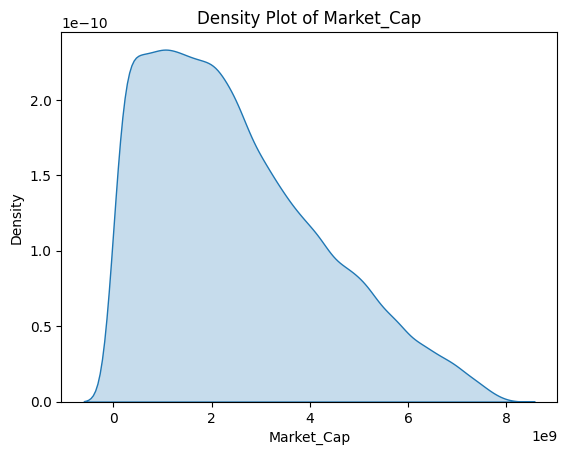

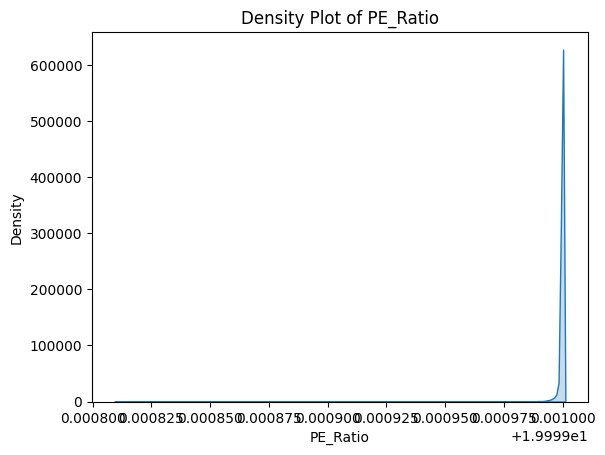

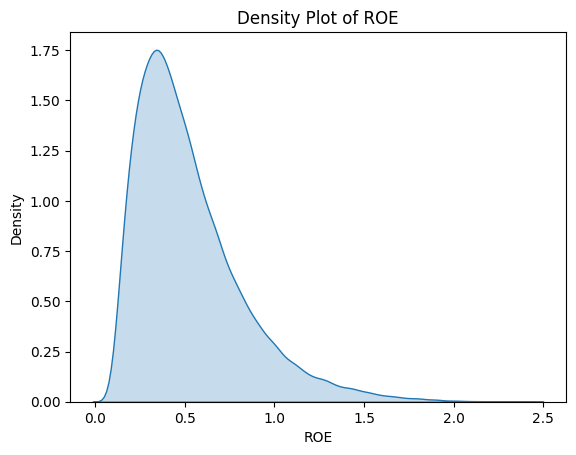

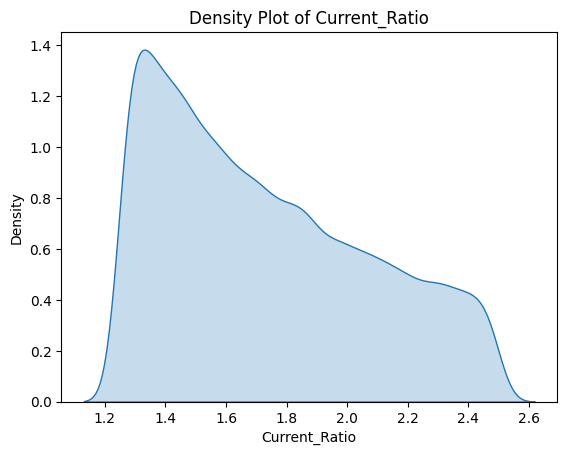

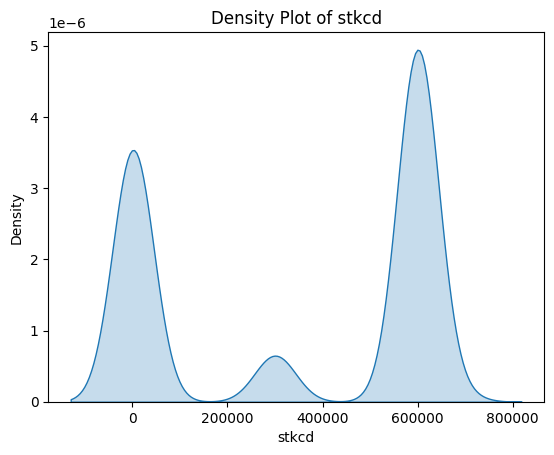

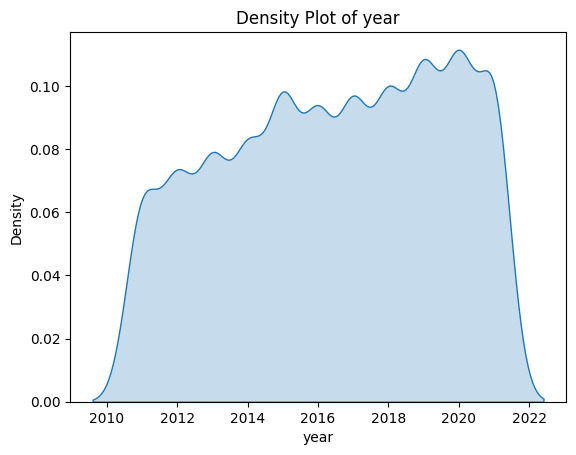

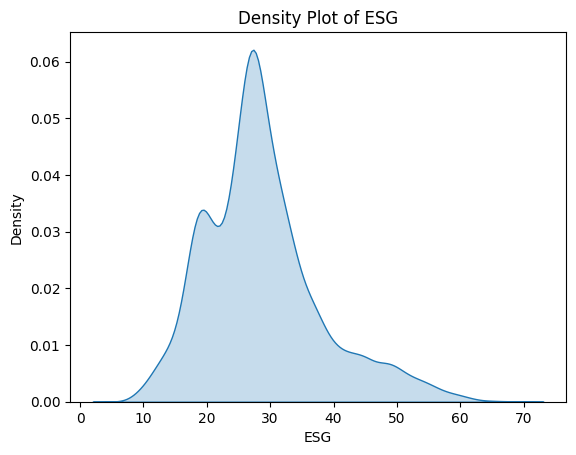

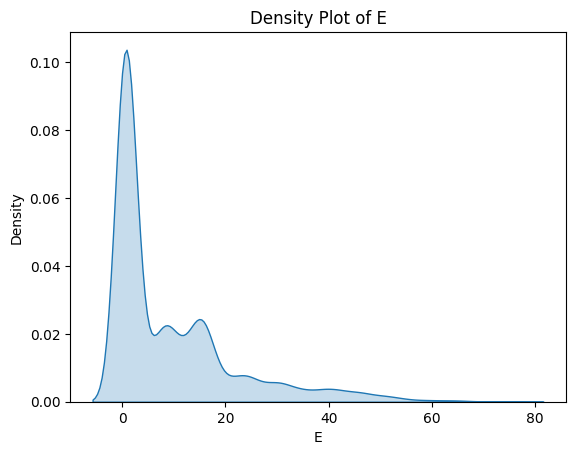

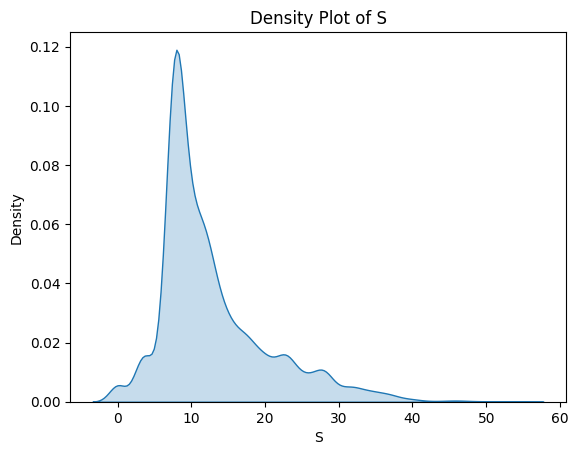

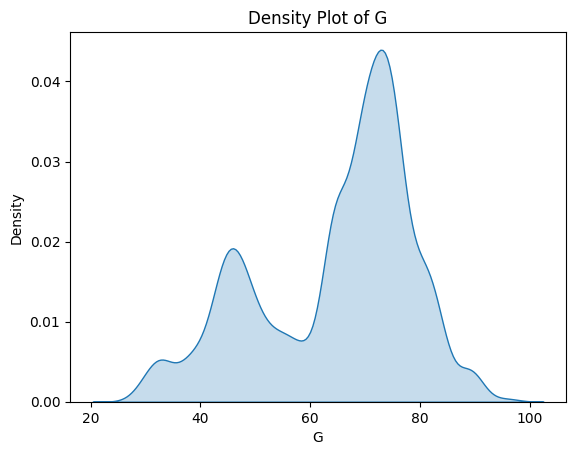

In [6]:
for column in df.columns:
  if df[column].dtype != 'object':
    plt.figure()
    sns.kdeplot(df[column], fill=True)
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()


Plotting and analyzing missing data in our dataset

<Axes: >

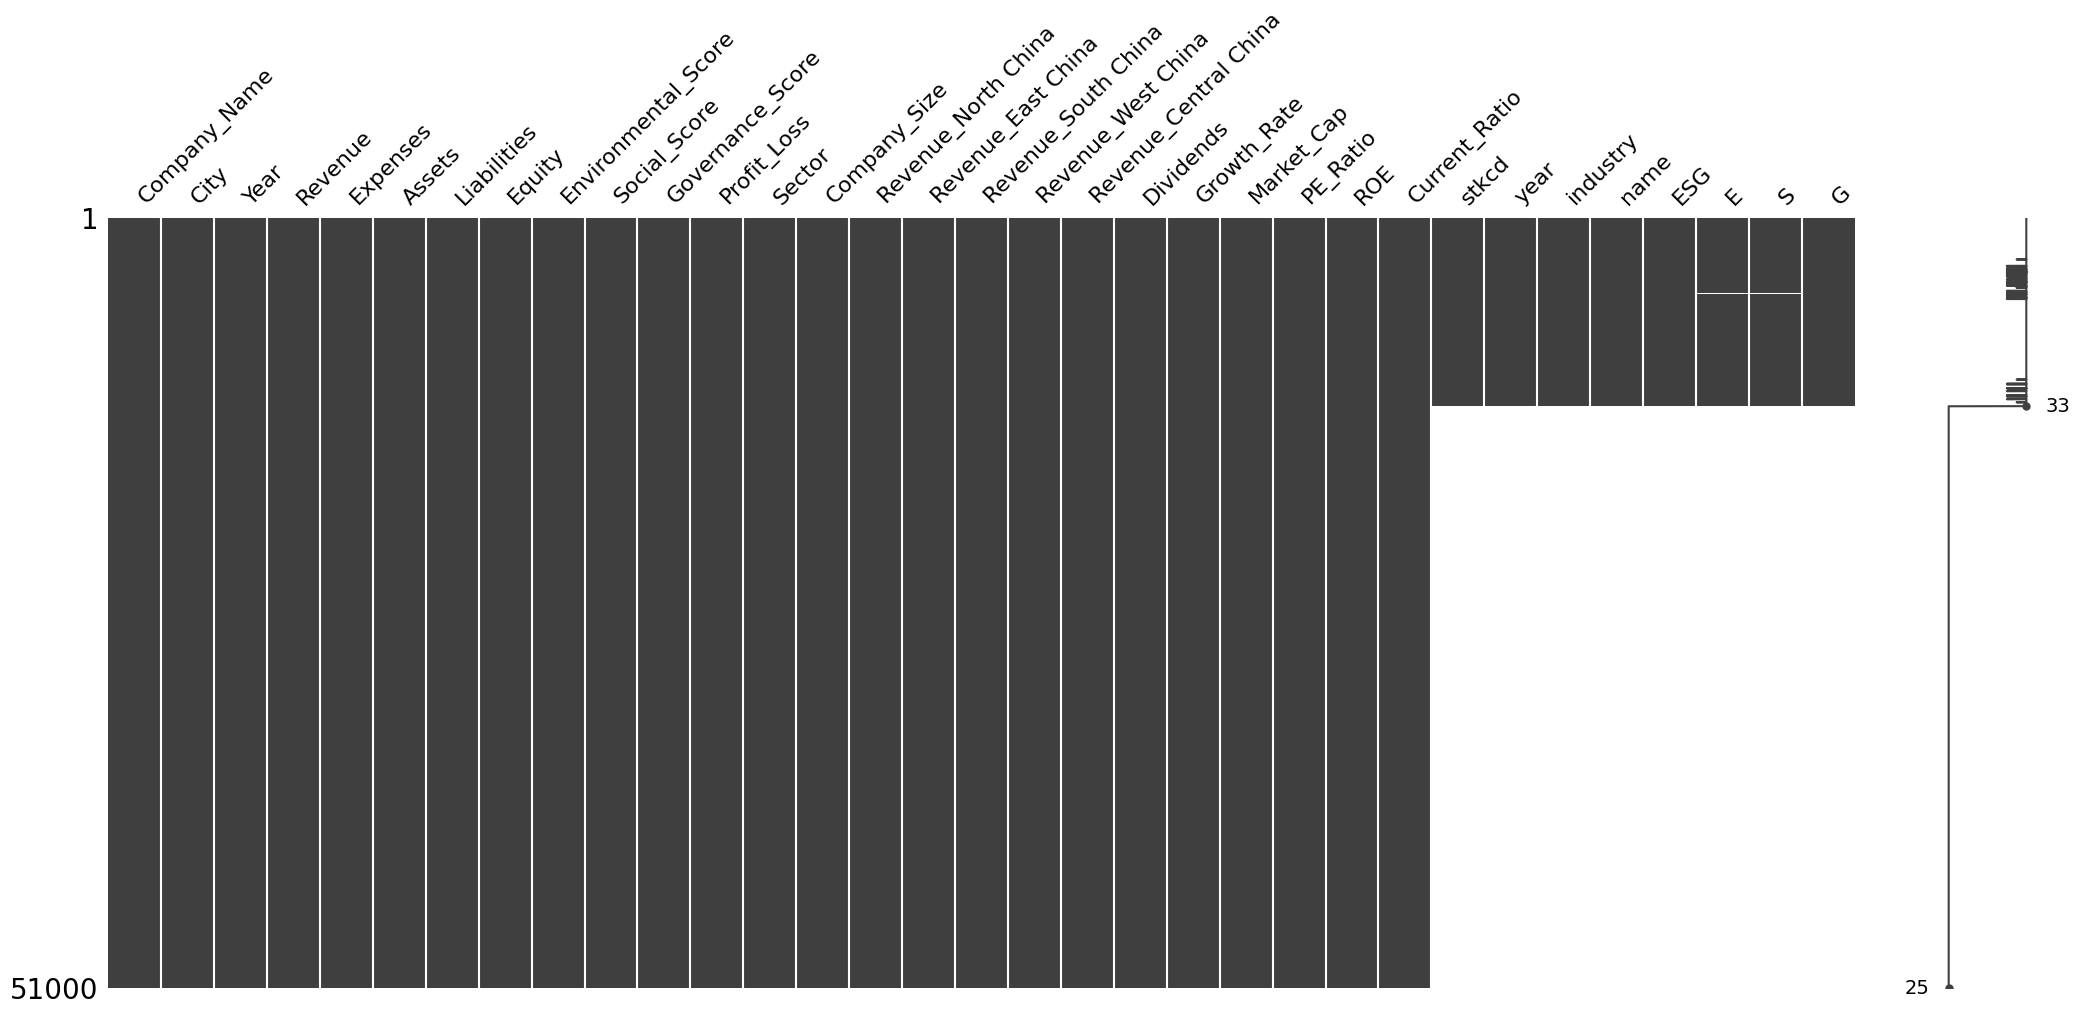

In [7]:
import missingno as msno
msno.matrix(df)


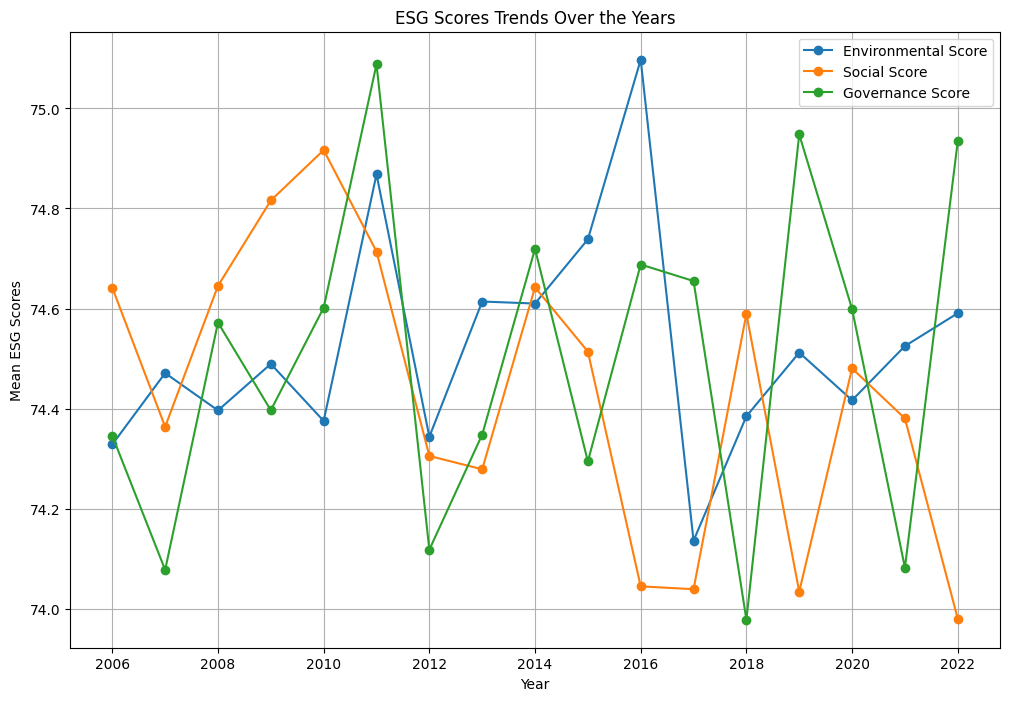

In [8]:
# Visualize ESG trends over the years

# Calculate mean ESG scores per year
esg_trends = df.groupby('Year')[['Environmental_Score', 'Social_Score', 'Governance_Score']].mean().reset_index()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Plot the trends
plt.plot(esg_trends['Year'], esg_trends['Environmental_Score'], label='Environmental Score', marker='o')
plt.plot(esg_trends['Year'], esg_trends['Social_Score'], label='Social Score', marker='o')
plt.plot(esg_trends['Year'], esg_trends['Governance_Score'], label='Governance Score', marker='o')

# Customize the plot
plt.title('ESG Scores Trends Over the Years')
plt.xlabel('Year')
plt.ylabel('Mean ESG Scores')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Imputing missing numerical values with mean
numerical_columns = ['stkcd', 'year', 'ESG', 'E', 'S', 'G']
imputer = SimpleImputer(strategy='mean')
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

# Dropping rows with remaining missing values in essential columns
df = df.dropna(subset=['Revenue', 'Profit_Loss', 'ROE', 'Current_Ratio'])

# Verifying the data cleaning
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company_Name           51000 non-null  object 
 1   City                   51000 non-null  object 
 2   Year                   51000 non-null  int64  
 3   Revenue                51000 non-null  int64  
 4   Expenses               51000 non-null  float64
 5   Assets                 51000 non-null  float64
 6   Liabilities            51000 non-null  float64
 7   Equity                 51000 non-null  float64
 8   Environmental_Score    51000 non-null  int64  
 9   Social_Score           51000 non-null  int64  
 10  Governance_Score       51000 non-null  int64  
 11  Profit_Loss            51000 non-null  float64
 12  Sector                 51000 non-null  object 
 13  Company_Size           51000 non-null  object 
 14  Revenue_North China    51000 non-null  float64
 15  Re

Feature Engineering
Encode Categorical Data and Create New Features:
Encode categorical variables using one-hot encoding.
Create new features such as Revenue_Growth, Profit_Margin, Debt_to_Equity, Asset_Turnover_Ratio, ESG_Interaction_1, ESG_Interaction_2 and financial_stability

In [10]:

# Encoding categorical data
df = pd.get_dummies(df, columns=['Company_Name', 'City', 'Sector', 'Company_Size', 'industry', 'name'])

# Creating new features
df['Revenue_Growth'] = df['Revenue'].pct_change()
df['Profit_Margin'] = df['Profit_Loss'] / df['Revenue']
df['Debt_to_Equity'] = df['Liabilities'] / df['Equity']
df['Asset_Turnover_Ratio'] = df['Revenue'] / df['Assets']
df['ESG_Interaction_1'] = df['Environmental_Score'] * df['Social_Score']
df['ESG_Interaction_2'] = df['Social_Score'] * df['Governance_Score']

# Dropping rows with missing values after creating new features
df = df.dropna(subset=['Revenue_Growth', 'Profit_Margin', 'Debt_to_Equity', 'Asset_Turnover_Ratio'])

# Verifying the feature engineering done
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 50999 entries, 1 to 50999
Columns: 4545 entries, Year to ESG_Interaction_2
dtypes: bool(4512), float64(26), int64(7)
memory usage: 232.7 MB
None
   Year    Revenue      Expenses        Assets   Liabilities        Equity  \
1  2007  779287829  6.416042e+08  1.297214e+09  1.013276e+09  2.839379e+08   
2  2008  548069395  4.431457e+08  7.706934e+08  4.213797e+08  3.493138e+08   
3  2009   10255180  8.621672e+06  1.343356e+07  7.316452e+06  6.117112e+06   
4  2010   16362625  1.415928e+07  2.836268e+07  2.105425e+07  7.308433e+06   
5  2011  644632098  5.333741e+08  9.505824e+08  5.998756e+08  3.507068e+08   

   Environmental_Score  Social_Score  Governance_Score   Profit_Loss  ...  \
1                   59            79                89  1.376836e+08  ...   
2                   90            97                98  1.049236e+08  ...   
3                   88            66                75  1.633508e+06  ...   
4                   73           

In [11]:
# Creating a 'financial_stability' column using the formula
df['financial_stability'] = (
    0.4 * df['ROE'] +
    0.2 * (1 / (df['Debt_to_Equity'] + 1e-6)) +  # Adding a small value to avoid division by zero
    0.15 * df['Current_Ratio'] +
    0.1 * df['Profit_Margin'] +
    0.1 * df['Revenue_Growth'] +
    0.05 * df['Asset_Turnover_Ratio']
)

# Handling potential infinities due to division by zero
df['financial_stability'] = df['financial_stability'].replace([np.inf, -np.inf], np.nan)
df['financial_stability'] = df['financial_stability'].fillna(df['financial_stability'].mean())

# Displaying the first few rows of the updated DataFrame
print(df[['ROE', 'Debt_to_Equity', 'Current_Ratio', 'Profit_Margin', 'Revenue_Growth', 'Asset_Turnover_Ratio', 'financial_stability']].head())



        ROE  Debt_to_Equity  Current_Ratio  Profit_Margin  Revenue_Growth  \
1  0.484907        3.568655       1.280218       0.176679        0.177715   
2  0.300371        1.206307       1.828976       0.191442       -0.296705   
3  0.267039        1.196063       1.836076       0.159286       -0.981289   
4  0.301480        2.880815       1.347124       0.134657        0.595547   
5  0.317239        1.710476       1.584633       0.172592       38.396619   

   Asset_Turnover_Ratio  financial_stability  
1              0.600739             0.507516  
2              0.711138             0.585321  
3              0.763400             0.505412  
4              0.576907             0.493951  
5              0.678144             4.372345  


In [12]:
import statsmodels.api as sm

# Defining the dependent and independent variables
X = df[['ROE', 'Debt_to_Equity', 'Current_Ratio', 'Profit_Margin', 'Revenue_Growth', 'Asset_Turnover_Ratio']]
y = df['financial_stability']

# Adding a constant to the independent variables (for the intercept in the regression)
X = sm.add_constant(X)

# Fitting the OLS regression model
model = sm.OLS(y, X).fit()

# Printing the regression summary
print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     financial_stability   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                  1.000
Method:                  Least Squares   F-statistic:                 7.401e+19
Date:                 Thu, 22 Aug 2024   Prob (F-statistic):               0.00
Time:                         13:31:24   Log-Likelihood:             8.3348e+05
No. Observations:                50999   AIC:                        -1.667e+06
Df Residuals:                    50992   BIC:                        -1.667e+06
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

Phase 3: Dimensionality Reduction and Model Building

In [13]:
# The number of columns has increased to 4546 indicating a large number of unique categories in the categorical variables.
# We now reduce dimensionality and verify feature engineering as it can make the model more prone to overfitting and increase computational costs

# Defining features and target
features = [
    'Revenue_Growth', 'Profit_Margin', 'Debt_to_Equity', 'Current_Ratio', 'Asset_Turnover_Ratio', 'Environmental_Score', 'Social_Score', 'Governance_Score', 'ESG_Interaction_1', 'ESG_Interaction_2'
    ] + [col for col in df.columns if col.startswith('Sector_') or col.startswith('Company_Size_')]


X = df[features]
y = df['financial_stability']

# Normalize the data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Applying PCA
pca = PCA(n_components=0.95) #Retaining 95% of the variance
X_reduced = pca.fit_transform(X_scaled)


# Verifying normalization and dimensionality reduction
print(X_reduced[:5])
print(f'Number of components retained: {pca.n_components_}')

[[ 0.33170294 -0.41285412  2.36535395  1.78278152 -0.91436877 -0.96936666
   1.7091685  -0.61691039 -0.28247011 -0.28717367 -0.35999942  1.11323519
  -0.06743216]
 [ 4.03931112 -0.4773244  -0.54419174  0.63140268 -0.27614979  2.16407255
   0.04088069 -0.63408342 -0.55238978 -0.52078327 -0.51959591  0.08799777
   0.23356027]
 [-0.1480329   4.2604433  -0.83172262 -0.66685242 -0.35264945  0.05403229
  -0.09563637  2.18832547  0.17667136 -0.91008211 -1.14372949  0.12922778
   0.89534979]
 [ 0.94263002  4.32003758  1.5198704  -0.52553876 -0.28988839  0.06181037
  -0.10783617  2.23295651  0.68648224  0.03630863 -0.79552375  1.98720174
   0.20922824]
 [ 0.41470636 -0.63104628  0.28063885 -0.49422226 -0.21197424  2.20256764
   0.0099405  -0.55975283  0.4288647   0.37811465  0.7887143   1.58287471
   1.44780401]]
Number of components retained: 13


Model Building and Evaluation

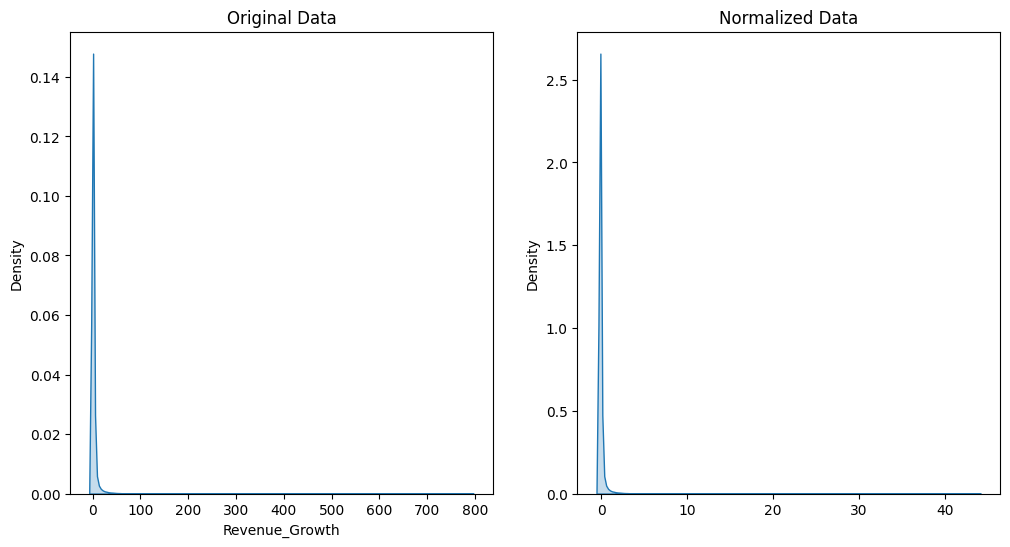

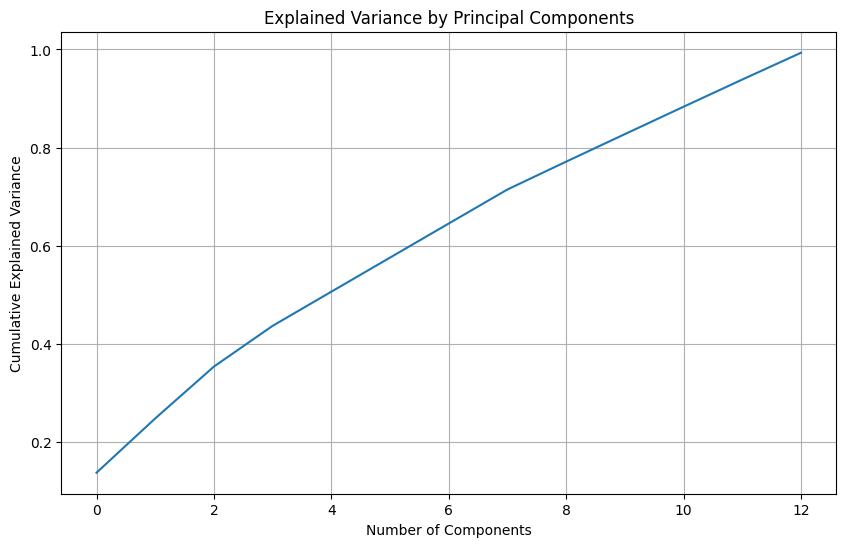

In [14]:
# Visualizing the effect of normalization
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
sns.kdeplot(X.iloc[:, 0], fill=True, ax=ax1)
ax1.set_title('Original Data')
sns.kdeplot(X_scaled[:, 0], fill=True, ax=ax2)
ax2.set_title('Normalized Data')
plt.show()

# Visualizing the explained variance by each principal component
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()



**Normalization Visualization:**

The two KDE plots compare the distribution of a feature before and after normalization.
* **Original Data:** The distribution might be skewed or have a wide range.
* **Normalized Data:** The distribution is more centered around zero and has a standard deviation of 1. This helps algorithms converge faster and prevents features with larger scales from dominating the learning process.

**PCA Explained Variance Visualization:**

This plot shows the cumulative explained variance as we increase the number of principal components.
* The curve indicates how much of the total variance in the data is captured by including more components.
* The elbow point of the curve suggests a good trade-off between dimensionality reduction and information retention. In this case, selecting the number of components corresponding to the elbow point would capture a significant portion of the variance while reducing the dimensionality of the data.


In [15]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=28)

Random Forest and Gradient Boosting Machines

In [17]:

# Ensure X_train and y_train are pandas DataFrame/Series
X_train = pd.DataFrame(X_train)  # Convert to DataFrame if it's a NumPy array
y_train = pd.Series(y_train)     # Convert to Series if it's a NumPy array

# Sample a subset of the data for faster hyperparameter tuning
np.random.seed(28)
sample_indices = np.random.choice(len(X_train), size=int(0.5 * len(X_train)), replace=False)
X_train_sample = X_train.iloc[sample_indices]
y_train_sample = y_train.iloc[sample_indices]


# Define objective functions for Optuna
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Initialize the RandomForestRegressor model here
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=28
    )


    scores = cross_val_score(model, X_train_sample, y_train_sample, cv=3, scoring='neg_mean_squared_error')
    return -scores.mean()



def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 10)

    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=28,
        validation_fraction=0.1,  # Early stopping
        n_iter_no_change=10
    )

    scores = cross_val_score(model, X_train_sample, y_train_sample, cv=3, scoring='neg_mean_squared_error')
    return -scores.mean()

# Create Optuna studies and optimize
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=20, n_jobs=4)

study_gb = optuna.create_study(direction='minimize')
study_gb.optimize(objective_gb, n_trials=20, n_jobs=4)

# Train models with best parameters
best_params_rf = study_rf.best_params
rf_model = RandomForestRegressor(**best_params_rf, random_state=28)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f'Best parameters for Random Forest: {best_params_rf}')

best_params_gb = study_gb.best_params
gb_model = GradientBoostingRegressor(**best_params_gb, random_state=28)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print(f'Best parameters for Gradient Boosting: {best_params_gb}')

# Evaluate models with best parameters
print(f'Best Random Forest - MSE: {mean_squared_error(y_test, y_pred_rf)}, R2: {r2_score(y_test, y_pred_rf)}')
print(f'Best Gradient Boosting - MSE: {mean_squared_error(y_test, y_pred_gb)}, R2: {r2_score(y_test, y_pred_gb)}')

[I 2024-08-22 14:09:02,503] A new study created in memory with name: no-name-7d42abec-e83e-4d02-a415-efff6bce9a41
[I 2024-08-22 14:11:04,214] Trial 2 finished with value: 0.09907752962483506 and parameters: {'n_estimators': 60, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.09907752962483506.
[I 2024-08-22 14:12:29,086] Trial 1 finished with value: 0.07447304069330385 and parameters: {'n_estimators': 128, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.07447304069330385.
[I 2024-08-22 14:13:31,746] Trial 4 finished with value: 0.18132737895778814 and parameters: {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.07447304069330385.
[I 2024-08-22 14:14:16,457] Trial 3 finished with value: 0.09601471560764167 and parameters: {'n_estimators': 167, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with v

Best parameters for Random Forest: {'n_estimators': 71, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1}
Best parameters for Gradient Boosting: {'n_estimators': 103, 'learning_rate': 0.25616775069214825, 'max_depth': 5}
Best Random Forest - MSE: 0.030578293400146336, R2: 0.9915484529082583
Best Gradient Boosting - MSE: 0.011041444091090388, R2: 0.996948250725587


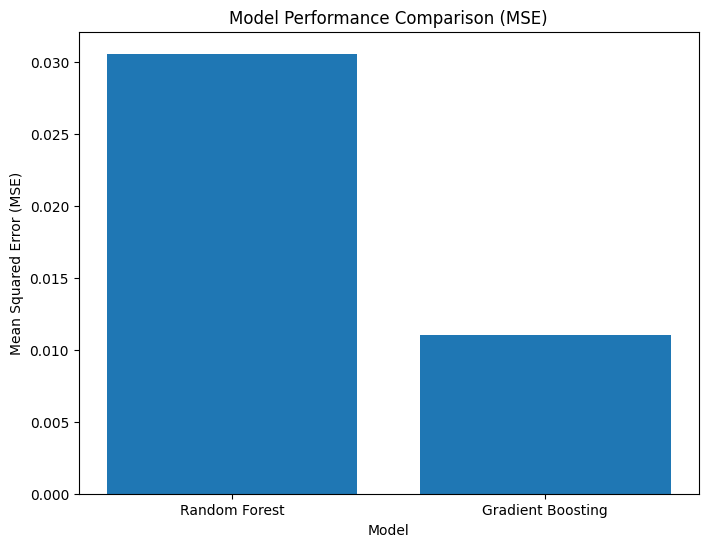

In [18]:
# Visualizing model performance
models = ['Random Forest', 'Gradient Boosting']
mse_scores = [mean_squared_error(y_test, y_pred_rf), mean_squared_error(y_test, y_pred_gb)]

plt.figure(figsize=(8, 6))
plt.bar(models, mse_scores)
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Performance Comparison (MSE)')
plt.show()


Training and Evaluating the XGBoost, CatBoost and LightGBM Model


Hyperparameter tuning for XGBoost


Phase 3: Model Training with Hyperparameter Tuning
Implement Optuna for XGBoost, CatBoost, and LightGBM

In [19]:
# Hyperparameter tuning and model training for XGBoost

def objective_xgb(trial):
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0)
    }
    xgb_model = xgb.XGBRegressor(**param)
    xgb_model.fit(X_train, y_train)
    preds = xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

study_xgb = optuna.create_study(direction='minimize', sampler=TPESampler())
study_xgb.optimize(objective_xgb, n_trials=50)
best_params_xgb = study_xgb.best_params
print(f'Best parameters for XGBoost: {best_params_xgb}')

# Training and evaluating the model with the best parameters
xgb_model = xgb.XGBRegressor(**best_params_xgb)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(f'XGBoost - MSE: {mean_squared_error(y_test, y_pred_xgb)}, R2: {r2_score(y_test, y_pred_xgb)}')

[I 2024-08-22 14:44:56,144] A new study created in memory with name: no-name-42499607-7276-44bd-a7f9-07676a987525
[I 2024-08-22 14:44:57,267] Trial 0 finished with value: 0.3157714113637946 and parameters: {'n_estimators': 123, 'learning_rate': 0.0937729948738492, 'max_depth': 6, 'subsample': 0.9321116734408642, 'colsample_bytree': 0.9277540874379961}. Best is trial 0 with value: 0.3157714113637946.
[I 2024-08-22 14:44:58,091] Trial 1 finished with value: 0.32028216447264113 and parameters: {'n_estimators': 152, 'learning_rate': 0.09551527749051433, 'max_depth': 5, 'subsample': 0.8138233625059779, 'colsample_bytree': 0.8227821964844387}. Best is trial 0 with value: 0.3157714113637946.
[I 2024-08-22 14:44:59,206] Trial 2 finished with value: 0.3117141622152558 and parameters: {'n_estimators': 290, 'learning_rate': 0.03707827508286983, 'max_depth': 4, 'subsample': 0.9163062067335794, 'colsample_bytree': 0.9929362419214418}. Best is trial 2 with value: 0.3117141622152558.
[I 2024-08-22 14

Best parameters for XGBoost: {'n_estimators': 275, 'learning_rate': 0.09527376892887911, 'max_depth': 3, 'subsample': 0.8438557559272614, 'colsample_bytree': 0.9000793630137601}
XGBoost - MSE: 0.26086830232081953, R2: 0.927898502609156


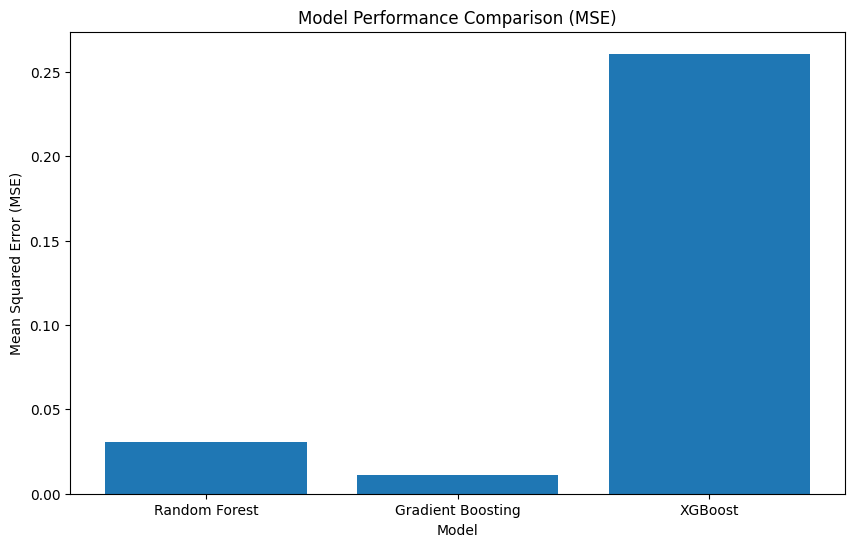

In [20]:
# Visualizing model performance
models = ['Random Forest', 'Gradient Boosting', 'XGBoost']
mse_scores = [mean_squared_error(y_test, y_pred_rf), mean_squared_error(y_test, y_pred_gb), mean_squared_error(y_test, y_pred_xgb)]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_scores)
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Performance Comparison (MSE)')
plt.show()


Hyperparameter Tuning for CatBoost

In [21]:
# Hyperparameter tuning for CatBoost
def objective_cat(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255)
    }
    cat_model = CatBoostRegressor(**param)
    cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=False)
    preds = cat_model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

study_cat = optuna.create_study(direction='minimize', sampler=TPESampler())
study_cat.optimize(objective_cat, n_trials=50)
best_params_cat = study_cat.best_params
print(f'Best parameters for CatBoost: {best_params_cat}')

# Training and evaluating the model with the best parameters
cat_model = CatBoostRegressor(**best_params_cat, loss_function='RMSE', verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
print(f'CatBoost - MSE: {mean_squared_error(y_test, y_pred_cat)}, R2: {r2_score(y_test, y_pred_cat)}')

[I 2024-08-22 14:45:57,022] A new study created in memory with name: no-name-2a4309d7-8b5a-4883-bedd-2ffce5bedfbb
[I 2024-08-22 14:46:00,784] Trial 0 finished with value: 0.30350004603172437 and parameters: {'iterations': 880, 'learning_rate': 0.040557044214467486, 'depth': 4, 'l2_leaf_reg': 3, 'bagging_temperature': 0.9680449772328074, 'border_count': 129}. Best is trial 0 with value: 0.30350004603172437.
[I 2024-08-22 14:46:04,018] Trial 1 finished with value: 0.4698868333298262 and parameters: {'iterations': 871, 'learning_rate': 0.03132838610571339, 'depth': 8, 'l2_leaf_reg': 6, 'bagging_temperature': 0.6396496100302966, 'border_count': 70}. Best is trial 0 with value: 0.30350004603172437.
[I 2024-08-22 14:46:19,803] Trial 2 finished with value: 0.2982894256412006 and parameters: {'iterations': 782, 'learning_rate': 0.03975582266297819, 'depth': 10, 'l2_leaf_reg': 6, 'bagging_temperature': 0.8857250525214025, 'border_count': 214}. Best is trial 2 with value: 0.2982894256412006.
[I 

Best parameters for CatBoost: {'iterations': 886, 'learning_rate': 0.07455032225873086, 'depth': 5, 'l2_leaf_reg': 7, 'bagging_temperature': 0.05959916776449105, 'border_count': 210}
CatBoost - MSE: 0.23448194569776093, R2: 0.9351914385706575


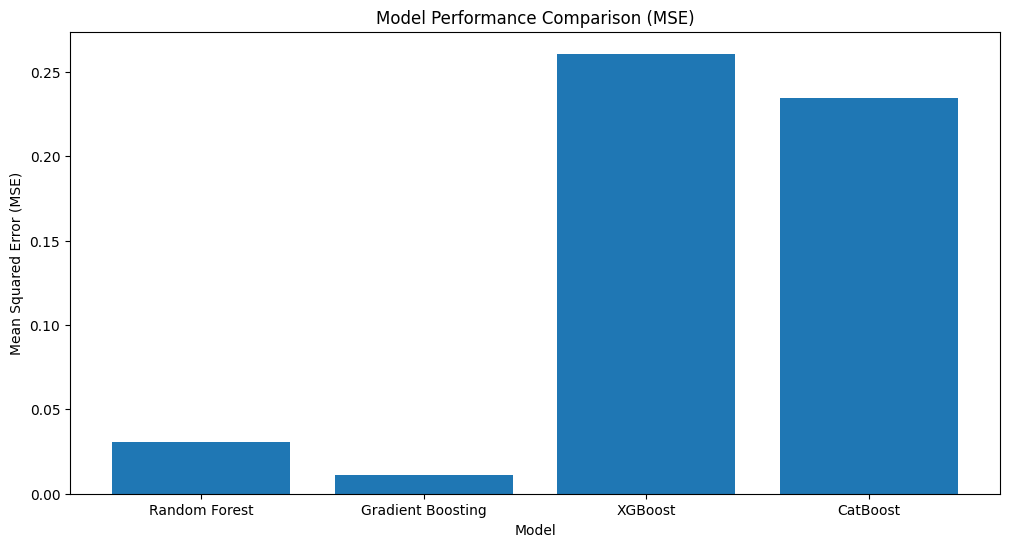

In [22]:
# Visualizing model performance
models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost']
mse_scores = [mean_squared_error(y_test, y_pred_rf),
              mean_squared_error(y_test, y_pred_gb),
              mean_squared_error(y_test, y_pred_xgb),
              mean_squared_error(y_test, y_pred_cat)]

plt.figure(figsize=(12, 6))
plt.bar(models, mse_scores)
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Performance Comparison (MSE)')
plt.show()


Hyperparameter Tuning for LightGBM

In [23]:
# Hyperparameter tuning for LightGBM
def objective_lgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0)
    }

    lgb_model = lgb.LGBMRegressor(**param)
    lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse')
    preds = lgb_model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

study_lgb = optuna.create_study(direction='minimize', sampler=TPESampler())
study_lgb.optimize(objective_lgb, n_trials=50)
best_params_lgb = study_lgb.best_params
print(f'Best parameters for LightGBM: {best_params_lgb}')

# Training and evaluating the model with the best parameters
lgb_model = lgb.LGBMRegressor(**best_params_lgb)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
print(f'LightGBM - MSE: {mean_squared_error(y_test, y_pred_lgb)}, R2: {r2_score(y_test, y_pred_lgb)}')


[I 2024-08-22 14:49:12,898] A new study created in memory with name: no-name-face0dda-1eac-4849-9206-a74fd79c6752


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:49:16,608] Trial 0 finished with value: 0.26617102478087706 and parameters: {'n_estimators': 438, 'learning_rate': 0.09747508888093467, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.5825988844604081, 'colsample_bytree': 0.7809319247758273, 'reg_alpha': 3.410564592624506, 'reg_lambda': 5.086148898856492}. Best is trial 0 with value: 0.26617102478087706.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:49:18,806] Trial 1 finished with value: 0.297407343965083 and parameters: {'n_estimators': 261, 'learning_rate': 0.02837700373298871, 'num_leaves': 122, 'max_depth': 8, 'min_child_samples': 44, 'subsample': 0.648487151688635, 'colsample_bytree': 0.756581265991887, 'reg_alpha': 7.929907779491321, 'reg_lambda': 3.587999370487916}. Best is trial 0 with value: 0.26617102478087706.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:49:21,739] Trial 2 finished with value: 0.41411901499552534 and parameters: {'n_estimators': 311, 'learning_rate': 0.015517737138392568, 'num_leaves': 166, 'max_depth': 10, 'min_child_samples': 68, 'subsample': 0.5809914658872399, 'colsample_bytree': 0.5425101217724921, 'reg_alpha': 5.81978119574068, 'reg_lambda': 7.08998916197649}. Best is trial 0 with value: 0.26617102478087706.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:49:25,766] Trial 3 finished with value: 0.2901326224197326 and parameters: {'n_estimators': 561, 'learning_rate': 0.021354976135964873, 'num_leaves': 89, 'max_depth': 5, 'min_child_samples': 57, 'subsample': 0.7748224149099041, 'colsample_bytree': 0.8869809093259555, 'reg_alpha': 7.088058098402902, 'reg_lambda': 2.4338752416855747}. Best is trial 0 with value: 0.26617102478087706.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:49:27,734] Trial 4 finished with value: 0.29429329839424745 and parameters: {'n_estimators': 558, 'learning_rate': 0.06710567486920899, 'num_leaves': 225, 'max_depth': 4, 'min_child_samples': 78, 'subsample': 0.9196473651152768, 'colsample_bytree': 0.687017114719618, 'reg_alpha': 0.20908413490137168, 'reg_lambda': 5.10881525734918}. Best is trial 0 with value: 0.26617102478087706.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:49:30,392] Trial 5 finished with value: 0.35838937492293715 and parameters: {'n_estimators': 240, 'learning_rate': 0.016038417599006653, 'num_leaves': 226, 'max_depth': 10, 'min_child_samples': 35, 'subsample': 0.8652516853507561, 'colsample_bytree': 0.5046835674229261, 'reg_alpha': 2.892706898350305, 'reg_lambda': 0.6540951346431353}. Best is trial 0 with value: 0.26617102478087706.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:49:36,085] Trial 6 finished with value: 0.25853725577016984 and parameters: {'n_estimators': 687, 'learning_rate': 0.017622357397395032, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.663414010076756, 'colsample_bytree': 0.9971193608071993, 'reg_alpha': 7.803500750420009, 'reg_lambda': 5.751677187746755}. Best is trial 6 with value: 0.25853725577016984.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:49:43,996] Trial 7 finished with value: 0.2630417168937262 and parameters: {'n_estimators': 771, 'learning_rate': 0.0658358008581624, 'num_leaves': 46, 'max_depth': 10, 'min_child_samples': 93, 'subsample': 0.52581918681971, 'colsample_bytree': 0.8495648258959971, 'reg_alpha': 4.615859848981962, 'reg_lambda': 1.592013589278196}. Best is trial 6 with value: 0.25853725577016984.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:49:44,720] Trial 8 finished with value: 0.4093090714624431 and parameters: {'n_estimators': 176, 'learning_rate': 0.07383769762604389, 'num_leaves': 190, 'max_depth': 4, 'min_child_samples': 98, 'subsample': 0.6009285110433638, 'colsample_bytree': 0.7652821139173034, 'reg_alpha': 7.214647122031617, 'reg_lambda': 8.624527617381474}. Best is trial 6 with value: 0.25853725577016984.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-22 14:49:47,488] Trial 9 finished with value: 0.2814391400288966 and parameters: {'n_estimators': 800, 'learning_rate': 0.04733665785324376, 'num_leaves': 100, 'max_depth': 4, 'min_child_samples': 89, 'subsample': 0.5858662100423684, 'colsample_bytree': 0.6581098664354539, 'reg_alpha': 3.879498885860065, 'reg_lambda': 5.775953905927931}. Best is trial 6 with value: 0.25853725577016984.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:49:58,942] Trial 10 finished with value: 0.2659516857699206 and parameters: {'n_estimators': 990, 'learning_rate': 0.03951131311274986, 'num_leaves': 53, 'max_depth': -1, 'min_child_samples': 9, 'subsample': 0.7202110268053167, 'colsample_bytree': 0.9906134532445532, 'reg_alpha': 9.602894174855365, 'reg_lambda': 9.918462928367912}. Best is trial 6 with value: 0.25853725577016984.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:50:05,832] Trial 11 finished with value: 0.25974481826045875 and parameters: {'n_estimators': 750, 'learning_rate': 0.06306744527257245, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.5162761331841246, 'colsample_bytree': 0.9846882148712848, 'reg_alpha': 5.449527446186635, 'reg_lambda': 2.3154284894271555}. Best is trial 6 with value: 0.25853725577016984.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:50:12,472] Trial 12 finished with value: 0.24366452940698458 and parameters: {'n_estimators': 772, 'learning_rate': 0.055100263917845047, 'num_leaves': 32, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.500840911291494, 'colsample_bytree': 0.9876329733474597, 'reg_alpha': 9.778541918928067, 'reg_lambda': 3.5846748014852583}. Best is trial 12 with value: 0.24366452940698458.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:50:14,603] Trial 13 finished with value: 0.7277266015424437 and parameters: {'n_estimators': 920, 'learning_rate': 0.03688755564000261, 'num_leaves': 74, 'max_depth': 1, 'min_child_samples': 35, 'subsample': 0.7097644027080335, 'colsample_bytree': 0.9004940655248206, 'reg_alpha': 9.994789847625812, 'reg_lambda': 3.7951810699403983}. Best is trial 12 with value: 0.24366452940698458.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:50:21,208] Trial 14 finished with value: 0.2425008430457138 and parameters: {'n_estimators': 666, 'learning_rate': 0.08316408407965478, 'num_leaves': 152, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.806698970287533, 'colsample_bytree': 0.9470886472799778, 'reg_alpha': 8.621204926882376, 'reg_lambda': 6.35489440064851}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:50:23,360] Trial 15 finished with value: 0.27386375153426423 and parameters: {'n_estimators': 671, 'learning_rate': 0.08621534681033255, 'num_leaves': 152, 'max_depth': 2, 'min_child_samples': 6, 'subsample': 0.8101097500091994, 'colsample_bytree': 0.90764080168768, 'reg_alpha': 8.953869912998906, 'reg_lambda': 7.034204090481208}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:50:26,793] Trial 16 finished with value: 0.2637774129019974 and parameters: {'n_estimators': 452, 'learning_rate': 0.08355208766564665, 'num_leaves': 186, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.9770921186340755, 'colsample_bytree': 0.8381985355687755, 'reg_alpha': 8.665861821386668, 'reg_lambda': 3.5935722440736986}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:50:35,659] Trial 17 finished with value: 0.25555473209028223 and parameters: {'n_estimators': 864, 'learning_rate': 0.05236142382251846, 'num_leaves': 255, 'max_depth': 8, 'min_child_samples': 50, 'subsample': 0.8263234349188806, 'colsample_bytree': 0.9378152595133334, 'reg_alpha': 6.133826553909321, 'reg_lambda': 6.750707669828914}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:50:39,795] Trial 18 finished with value: 0.2768179682417784 and parameters: {'n_estimators': 654, 'learning_rate': 0.09823569259165929, 'num_leaves': 143, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.8607296208824556, 'colsample_bytree': 0.9526260576794952, 'reg_alpha': 1.9884563183810195, 'reg_lambda': 8.008261145183901}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:50:41,254] Trial 19 finished with value: 0.28730632952510843 and parameters: {'n_estimators': 452, 'learning_rate': 0.0799854368618532, 'num_leaves': 129, 'max_depth': 2, 'min_child_samples': 6, 'subsample': 0.7678229357151037, 'colsample_bytree': 0.8292071647942296, 'reg_alpha': 8.936796733959202, 'reg_lambda': 4.188906411229391}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-22 14:50:49,551] Trial 20 finished with value: 0.2514503260745926 and parameters: {'n_estimators': 872, 'learning_rate': 0.056913953980424564, 'num_leaves': 70, 'max_depth': 8, 'min_child_samples': 42, 'subsample': 0.9972772504404264, 'colsample_bytree': 0.6908085372140402, 'reg_alpha': 6.696879021657358, 'reg_lambda': 2.5845698931245438}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:50:56,915] Trial 21 finished with value: 0.2452696876868911 and parameters: {'n_estimators': 877, 'learning_rate': 0.05756441591475504, 'num_leaves': 80, 'max_depth': 8, 'min_child_samples': 44, 'subsample': 0.9976041222409385, 'colsample_bytree': 0.6712128617500294, 'reg_alpha': 6.7161947095840056, 'reg_lambda': 2.741738880727248}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:51:06,166] Trial 22 finished with value: 0.2598106746080994 and parameters: {'n_estimators': 951, 'learning_rate': 0.04650152022511275, 'num_leaves': 66, 'max_depth': 9, 'min_child_samples': 60, 'subsample': 0.9367112874233842, 'colsample_bytree': 0.6017335607650607, 'reg_alpha': 7.951812536991513, 'reg_lambda': 0.2910296751149586}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:51:11,450] Trial 23 finished with value: 0.25899946314975214 and parameters: {'n_estimators': 839, 'learning_rate': 0.07431717543790714, 'num_leaves': 31, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.9175168286497124, 'colsample_bytree': 0.6009561807913013, 'reg_alpha': 8.58458683898476, 'reg_lambda': 4.4285708596480235}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:51:17,203] Trial 24 finished with value: 0.24809690931332481 and parameters: {'n_estimators': 735, 'learning_rate': 0.05569594736156694, 'num_leaves': 90, 'max_depth': 6, 'min_child_samples': 46, 'subsample': 0.6744564435294561, 'colsample_bytree': 0.7045271513065289, 'reg_alpha': 9.392550866788788, 'reg_lambda': 1.4772883594222592}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:51:23,380] Trial 25 finished with value: 0.2626185454073011 and parameters: {'n_estimators': 652, 'learning_rate': 0.08884740637733936, 'num_leaves': 57, 'max_depth': 9, 'min_child_samples': 65, 'subsample': 0.8756305001828402, 'colsample_bytree': 0.9437658893447621, 'reg_alpha': 6.553706264330696, 'reg_lambda': 2.9687711853669505}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:51:29,484] Trial 26 finished with value: 0.24941024202109244 and parameters: {'n_estimators': 609, 'learning_rate': 0.03631367163232485, 'num_leaves': 171, 'max_depth': 9, 'min_child_samples': 38, 'subsample': 0.7212804448765607, 'colsample_bytree': 0.6239279127988588, 'reg_alpha': 4.919444723340361, 'reg_lambda': 6.245599985779886}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:51:37,818] Trial 27 finished with value: 0.24783160895466894 and parameters: {'n_estimators': 905, 'learning_rate': 0.05941166887286993, 'num_leaves': 140, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.8031082646365983, 'colsample_bytree': 0.8007857871612494, 'reg_alpha': 8.045624024407648, 'reg_lambda': 1.5967629331753783}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:51:43,449] Trial 28 finished with value: 0.25290821739612274 and parameters: {'n_estimators': 816, 'learning_rate': 0.07336554949821278, 'num_leaves': 77, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.9582599757060883, 'colsample_bytree': 0.8792951068119363, 'reg_alpha': 9.999493125077663, 'reg_lambda': 4.532853850751567}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:51:46,307] Trial 29 finished with value: 0.25523152352440265 and parameters: {'n_estimators': 504, 'learning_rate': 0.08954475026984593, 'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.6208008100562193, 'colsample_bytree': 0.806124492916587, 'reg_alpha': 7.286182570815164, 'reg_lambda': 3.1017967866911036}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:51:49,354] Trial 30 finished with value: 0.24975028948042252 and parameters: {'n_estimators': 368, 'learning_rate': 0.0933856370771469, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.8903649747314732, 'colsample_bytree': 0.7297034693272477, 'reg_alpha': 8.598039703720636, 'reg_lambda': 5.217977611960474}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:51:57,510] Trial 31 finished with value: 0.2525661344270205 and parameters: {'n_estimators': 921, 'learning_rate': 0.060295956896997016, 'num_leaves': 144, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.821428790836217, 'colsample_bytree': 0.7941466432128965, 'reg_alpha': 7.992804279579076, 'reg_lambda': 1.3217707926522513}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:52:05,312] Trial 32 finished with value: 0.2688942583104205 and parameters: {'n_estimators': 724, 'learning_rate': 0.049933201982682376, 'num_leaves': 135, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.7953900986115109, 'colsample_bytree': 0.7335180031775299, 'reg_alpha': 7.908946198475361, 'reg_lambda': 1.9282101564277405}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:52:11,862] Trial 33 finished with value: 0.24564915519514774 and parameters: {'n_estimators': 877, 'learning_rate': 0.04404431426490157, 'num_leaves': 173, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.5465571420003924, 'colsample_bytree': 0.6528450570032026, 'reg_alpha': 9.128527191121368, 'reg_lambda': 3.286738228817799}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:52:19,746] Trial 34 finished with value: 0.2477439552671208 and parameters: {'n_estimators': 988, 'learning_rate': 0.025485430618942297, 'num_leaves': 162, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.538927404520861, 'colsample_bytree': 0.6243088256725579, 'reg_alpha': 9.450976786645374, 'reg_lambda': 3.1141768331066126}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:52:26,131] Trial 35 finished with value: 0.26086303321023663 and parameters: {'n_estimators': 799, 'learning_rate': 0.04462758237142267, 'num_leaves': 186, 'max_depth': 8, 'min_child_samples': 52, 'subsample': 0.5459980936372867, 'colsample_bytree': 0.5557871707537169, 'reg_alpha': 9.111449976502591, 'reg_lambda': 3.989228321234239}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:52:30,718] Trial 36 finished with value: 0.2622161252863347 and parameters: {'n_estimators': 581, 'learning_rate': 0.03003444307372132, 'num_leaves': 197, 'max_depth': 6, 'min_child_samples': 32, 'subsample': 0.5035510453890281, 'colsample_bytree': 0.6610956553114165, 'reg_alpha': 7.3034517661232705, 'reg_lambda': 4.747599415177127}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:52:34,745] Trial 37 finished with value: 0.3124237990637971 and parameters: {'n_estimators': 848, 'learning_rate': 0.010566133499396259, 'num_leaves': 173, 'max_depth': 5, 'min_child_samples': 42, 'subsample': 0.6347210541778869, 'colsample_bytree': 0.5589785156902529, 'reg_alpha': 5.90048726948418, 'reg_lambda': 5.477786655557207}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:52:42,917] Trial 38 finished with value: 0.2650324725754083 and parameters: {'n_estimators': 698, 'learning_rate': 0.04132953306488741, 'num_leaves': 208, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.6847365736627591, 'colsample_bytree': 0.6548255524481659, 'reg_alpha': 8.39453118142863, 'reg_lambda': 6.266262702213548}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:52:47,568] Trial 39 finished with value: 0.272489504161587 and parameters: {'n_estimators': 779, 'learning_rate': 0.031993285927995205, 'num_leaves': 158, 'max_depth': 5, 'min_child_samples': 38, 'subsample': 0.5651033959928675, 'colsample_bytree': 0.9632463882586729, 'reg_alpha': 9.58641735985228, 'reg_lambda': 8.071409691055633}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-22 14:52:58,506] Trial 40 finished with value: 0.250474017589253 and parameters: {'n_estimators': 604, 'learning_rate': 0.06937222167959906, 'num_leaves': 123, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.564672994011679, 'colsample_bytree': 0.8656284330306564, 'reg_alpha': 0.3704864001689332, 'reg_lambda': 3.327015832857245}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:53:05,520] Trial 41 finished with value: 0.24730701467317712 and parameters: {'n_estimators': 990, 'learning_rate': 0.023415991296027037, 'num_leaves': 160, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.534709547499834, 'colsample_bytree': 0.6359680409532026, 'reg_alpha': 9.375437714074726, 'reg_lambda': 3.0003726208487027}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:53:13,915] Trial 42 finished with value: 0.2512916531979402 and parameters: {'n_estimators': 956, 'learning_rate': 0.024088973478038653, 'num_leaves': 172, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.5000201558151858, 'colsample_bytree': 0.5893717843062987, 'reg_alpha': 9.34616246964543, 'reg_lambda': 2.5491315645869337}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:53:20,669] Trial 43 finished with value: 0.2647850231464848 and parameters: {'n_estimators': 878, 'learning_rate': 0.05254087267325372, 'num_leaves': 211, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.5887293944883282, 'colsample_bytree': 0.6312620608292818, 'reg_alpha': 9.967075557204414, 'reg_lambda': 2.1820024906791335}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:53:21,628] Trial 44 finished with value: 0.2933494481250576 and parameters: {'n_estimators': 106, 'learning_rate': 0.03244356086598113, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.6104265625570454, 'colsample_bytree': 0.6774192753226271, 'reg_alpha': 7.531879706975273, 'reg_lambda': 2.7716597279851465}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:53:27,928] Trial 45 finished with value: 0.26505604723878046 and parameters: {'n_estimators': 956, 'learning_rate': 0.06480816405657475, 'num_leaves': 156, 'max_depth': 4, 'min_child_samples': 57, 'subsample': 0.5375275580035964, 'colsample_bytree': 0.9209078640473434, 'reg_alpha': 6.68348148269835, 'reg_lambda': 3.575773321837361}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:53:36,462] Trial 46 finished with value: 0.25047569642030354 and parameters: {'n_estimators': 1000, 'learning_rate': 0.02036159560491257, 'num_leaves': 46, 'max_depth': 8, 'min_child_samples': 31, 'subsample': 0.5567255586673608, 'colsample_bytree': 0.7138787294481292, 'reg_alpha': 4.176234829338492, 'reg_lambda': 1.0550342644753574}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:53:43,864] Trial 47 finished with value: 0.2590240933888777 and parameters: {'n_estimators': 907, 'learning_rate': 0.0786969880221938, 'num_leaves': 151, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.5198895840870306, 'colsample_bytree': 0.7621854613164791, 'reg_alpha': 8.41947992074902, 'reg_lambda': 4.049091889117982}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:53:47,673] Trial 48 finished with value: 0.29924480503699485 and parameters: {'n_estimators': 762, 'learning_rate': 0.04164364998252424, 'num_leaves': 99, 'max_depth': 6, 'min_child_samples': 82, 'subsample': 0.8436403544455745, 'colsample_bytree': 0.5112145761123981, 'reg_alpha': 9.134252600061776, 'reg_lambda': 4.959355370618501}. Best is trial 14 with value: 0.2425008430457138.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-08-22 14:53:52,323] Trial 49 finished with value: 0.2836111072592424 and parameters: {'n_estimators': 832, 'learning_rate': 0.011280174010645646, 'num_leaves': 128, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.7438502410988181, 'colsample_bytree': 0.9699383709105646, 'reg_alpha': 5.462825410539161, 'reg_lambda': 2.0136296351830945}. Best is trial 14 with value: 0.2425008430457138.


Best parameters for LightGBM: {'n_estimators': 666, 'learning_rate': 0.08316408407965478, 'num_leaves': 152, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.806698970287533, 'colsample_bytree': 0.9470886472799778, 'reg_alpha': 8.621204926882376, 'reg_lambda': 6.35489440064851}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 40799, number of used features: 13
[LightGBM] [Info] Start training from score 0.924628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

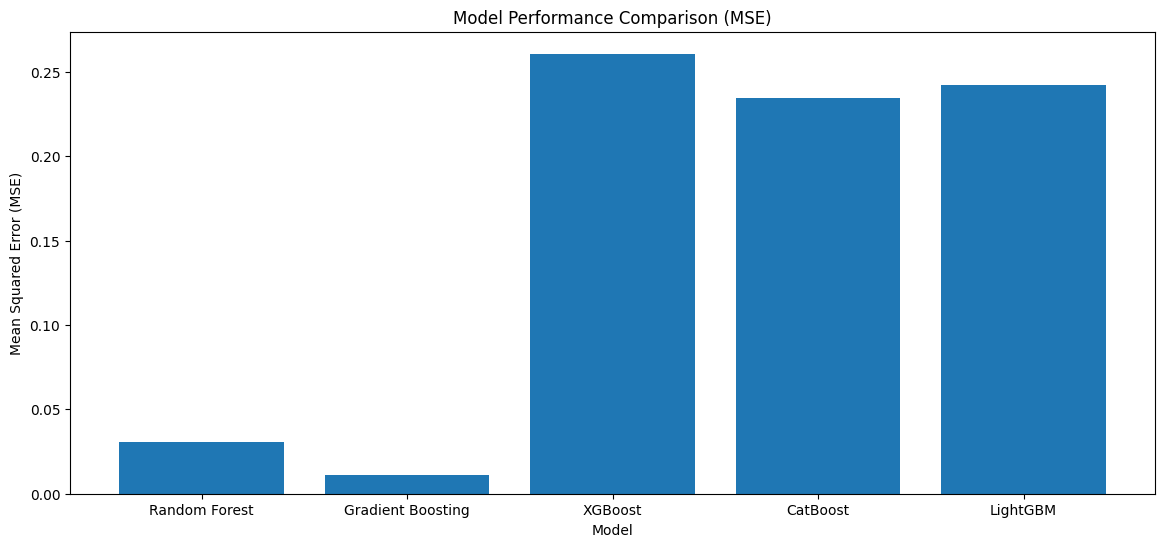

In [24]:
# Visualizing model performance
models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost', 'LightGBM']
mse_scores = [mean_squared_error(y_test, y_pred_rf),
              mean_squared_error(y_test, y_pred_gb),
              mean_squared_error(y_test, y_pred_xgb),
              mean_squared_error(y_test, y_pred_cat),
              mean_squared_error(y_test, y_pred_lgb)]

plt.figure(figsize=(14, 6))
plt.bar(models, mse_scores)
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Performance Comparison (MSE)')
plt.show()


In [25]:
# Comparing the performance of all the models
models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost', 'LightGBM']
mse_scores = [mean_squared_error(y_test, y_pred_rf),
              mean_squared_error(y_test, y_pred_gb),
              mean_squared_error(y_test, y_pred_xgb),
              mean_squared_error(y_test, y_pred_cat),
              mean_squared_error(y_test, y_pred_lgb)
              ]

r2_scores = [
    r2_score(y_test, y_pred_rf),
    r2_score(y_test, y_pred_gb),
    r2_score(y_test, y_pred_xgb),
    r2_score(y_test, y_pred_cat),
    r2_score(y_test, y_pred_lgb)
    ]


performance_df = pd.DataFrame({
    'Model': models,
    'MSE': mse_scores,
    'R2': r2_scores
    })

print(performance_df)


               Model       MSE        R2
0      Random Forest  0.030578  0.991548
1  Gradient Boosting  0.011041  0.996948
2            XGBoost  0.260868  0.927899
3           CatBoost  0.234482  0.935191
4           LightGBM  0.242501  0.932975


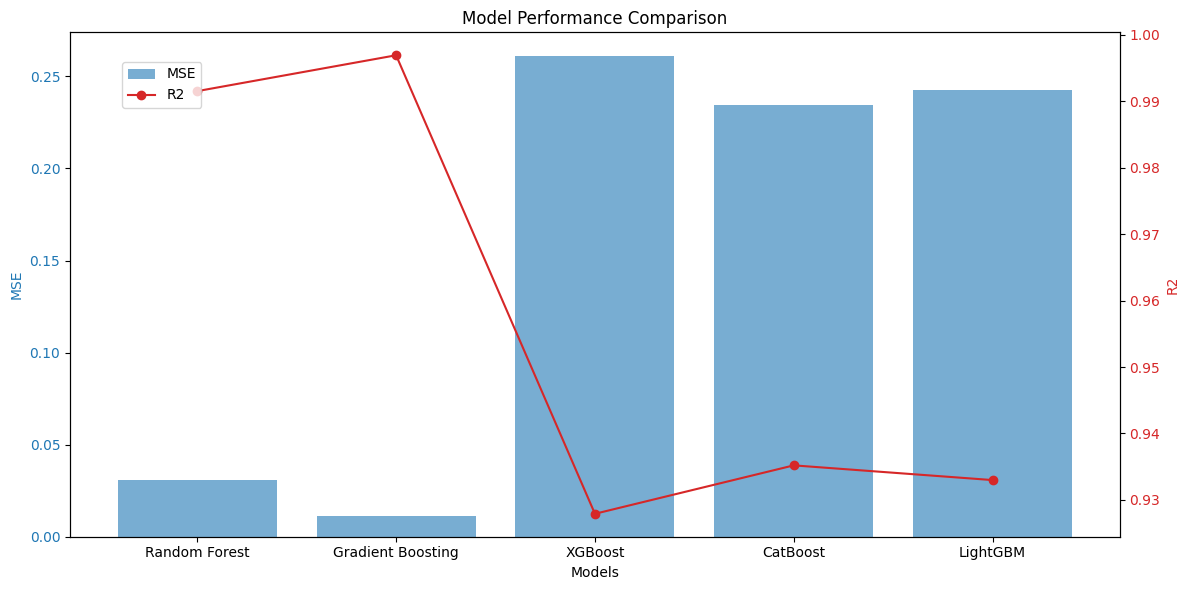

In [26]:
# Creating a combined plot for MSE and R2 scores
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting MSE scores
color = 'tab:blue'
ax1.set_xlabel('Models')
ax1.set_ylabel('MSE', color=color)
ax1.bar(models, mse_scores, color=color, alpha=0.6, label='MSE')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for R2 scores
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R2', color=color)
ax2.plot(models, r2_scores, color=color, marker='o', label='R2')
ax2.tick_params(axis='y', labelcolor=color)

# Adding titles and labels
plt.title('Model Performance Comparison')
fig.tight_layout()

# Adding legend
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

# Displaying the plot
plt.show()


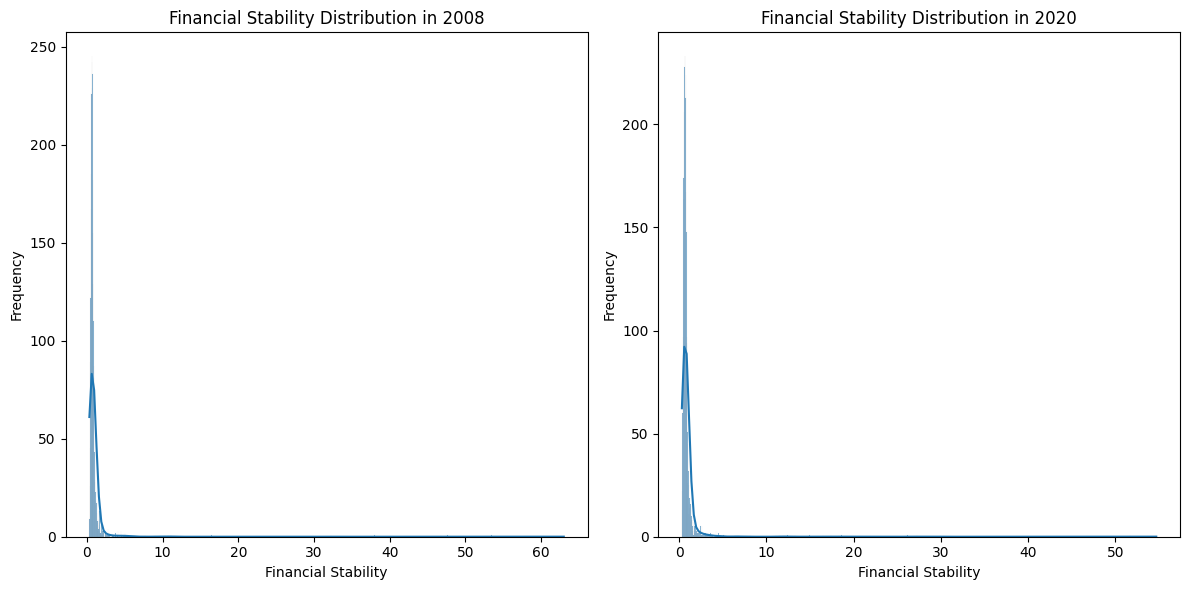

**T-statistic:** 0.26

**P-value:** 0.799

**Conclusion:** There is no statistically significant difference in financial stability between 2008 and 2020.

In [27]:

# Filter the DataFrame for the years 2008 and 2020
df_2008 = df[df['Year'] == 2008]
df_2020 = df[df['Year'] == 2020]

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for 2008
sns.histplot(df_2008['financial_stability'], kde=True, ax=axes[0])
axes[0].set_title('Financial Stability Distribution in 2008')
axes[0].set_xlabel('Financial Stability')
axes[0].set_ylabel('Frequency')

# Plot for 2020
sns.histplot(df_2020['financial_stability'], kde=True, ax=axes[1])
axes[1].set_title('Financial Stability Distribution in 2020')
axes[1].set_xlabel('Financial Stability')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Statistical comparison
from scipy import stats

# Perform a t-test to compare means
t_statistic, p_value = stats.ttest_ind(df_2008['financial_stability'], df_2020['financial_stability'], equal_var=False)

display(Markdown(f"**T-statistic:** {t_statistic:.2f}"))
display(Markdown(f"**P-value:** {p_value:.3f}"))
if p_value < 0.05:
    display(Markdown("**Conclusion:** There is a statistically significant difference in financial stability between 2008 and 2020."))
else:
    display(Markdown("**Conclusion:** There is no statistically significant difference in financial stability between 2008 and 2020."))



Phase 4: SHAP analysis and plotting summary plots for each model

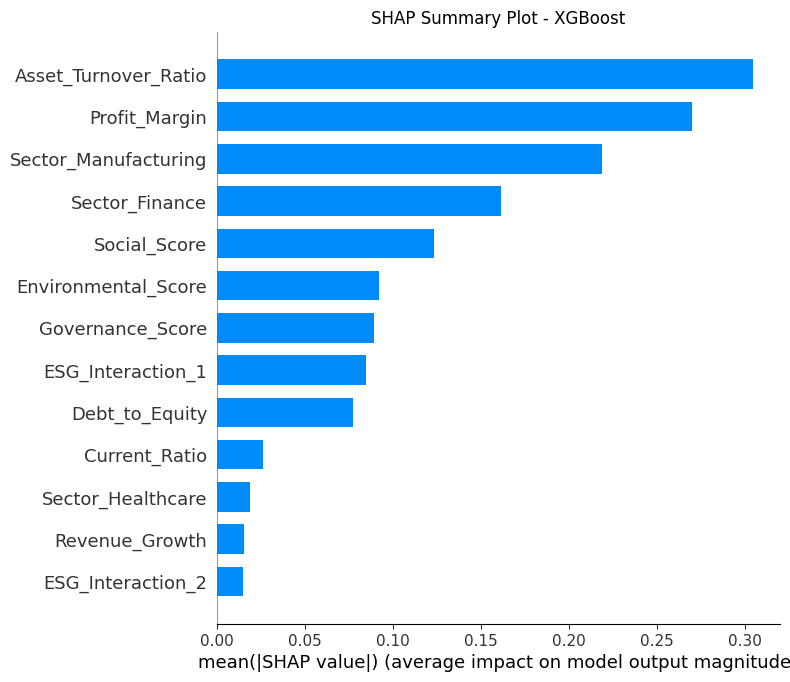

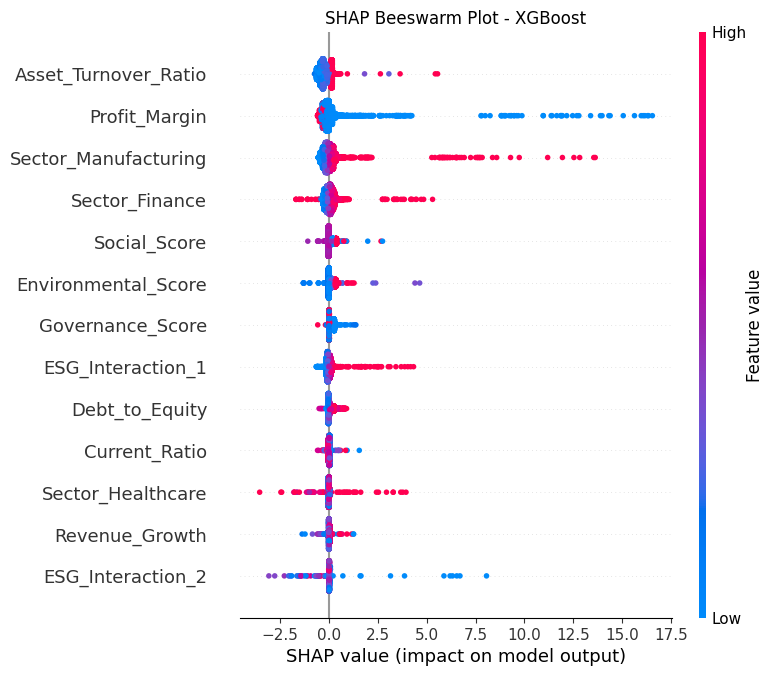

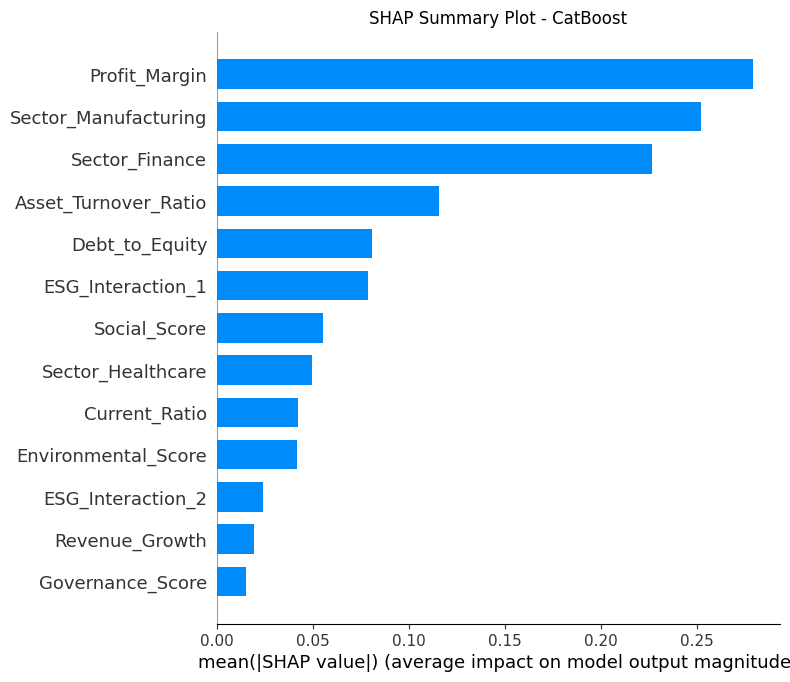

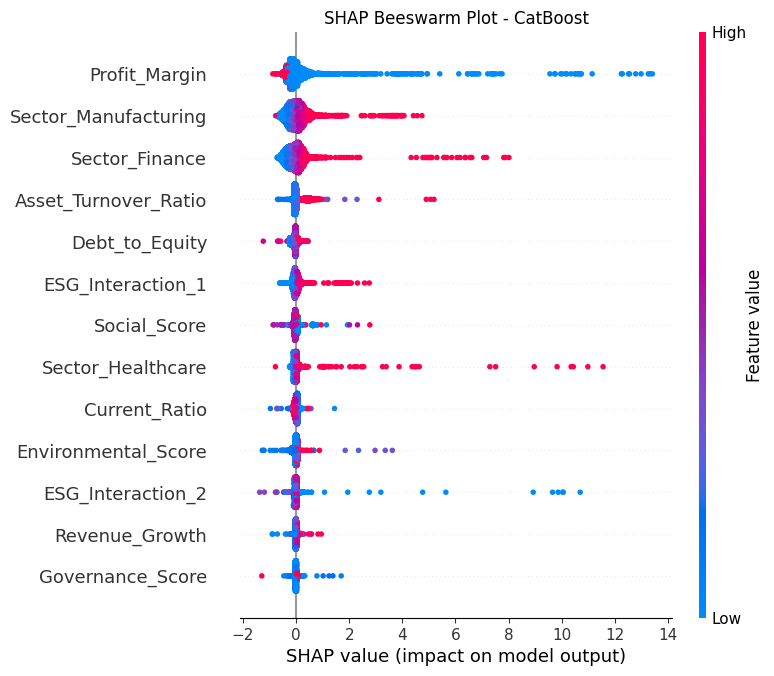

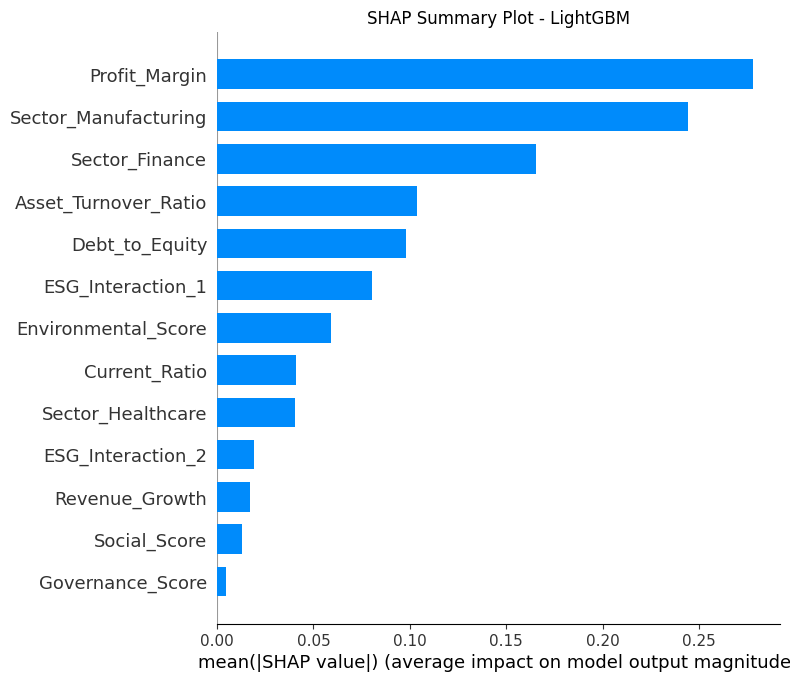

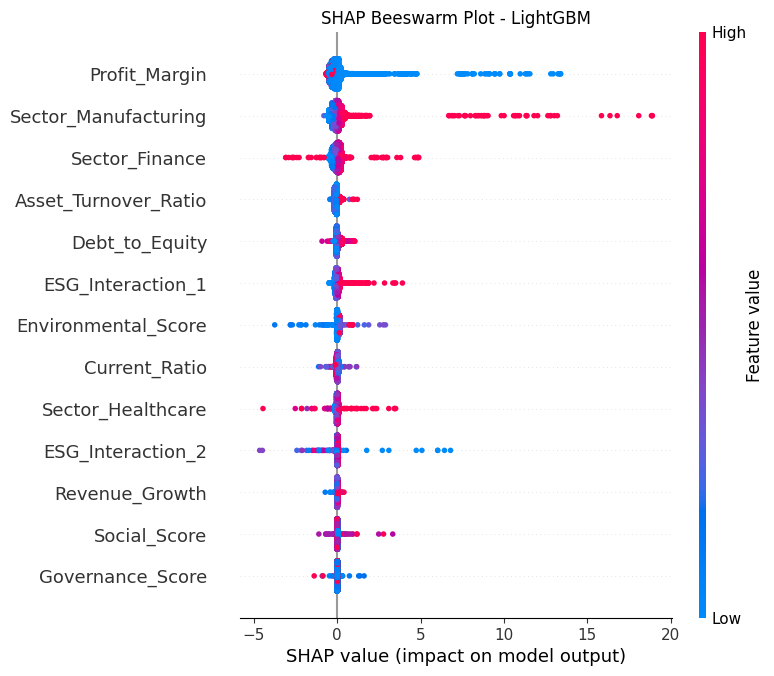

Shape of X_test: (10200, 13)
Number of features expected: 18
Features: ['Revenue_Growth', 'Profit_Margin', 'Debt_to_Equity', 'Current_Ratio', 'Asset_Turnover_Ratio', 'Environmental_Score', 'Social_Score', 'Governance_Score', 'ESG_Interaction_1', 'ESG_Interaction_2', 'Sector_Finance', 'Sector_Healthcare', 'Sector_Manufacturing', 'Sector_Services', 'Sector_Technology', 'Company_Size_Large', 'Company_Size_Medium', 'Company_Size_Small']


In [28]:
# List of actual features that match the columns of X_test
# Adjusting this list based on the actual columns in X_test after preprocessing
adjusted_features = [
    'Revenue_Growth', 'Profit_Margin', 'Debt_to_Equity', 'Current_Ratio', 'Asset_Turnover_Ratio',
    'Environmental_Score', 'Social_Score', 'Governance_Score', 'ESG_Interaction_1', 'ESG_Interaction_2',
    'Sector_Finance', 'Sector_Healthcare', 'Sector_Manufacturing'
    # Add or remove features as needed to match the 13 columns in X_test
]

# Now we use the adjusted_features list for the DataFrame creation
X_test = pd.DataFrame(X_test, columns=adjusted_features)

# Proceeding with SHAP analysis
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

shap.summary_plot(shap_values_xgb, X_test, plot_type='bar', show=False)
plt.title('SHAP Summary Plot - XGBoost')
plt.show()

shap.summary_plot(shap_values_xgb, X_test, show=False)
plt.title('SHAP Beeswarm Plot - XGBoost')
plt.show()

# Convert X_test column names to numerical indices
X_test_numeric = X_test.copy()
X_test_numeric.columns = range(X_test_numeric.shape[1])

# Use X_test_numeric for SHAP analysis with CatBoost
explainer_cat = shap.Explainer(cat_model)
shap_values_cat = explainer_cat.shap_values(X_test_numeric)

# SHAP summary plots for the CatBoost model
shap.summary_plot(shap_values_cat, X_test, plot_type='bar', show=False)
plt.title('SHAP Summary Plot - CatBoost')
plt.show()

shap.summary_plot(shap_values_cat, X_test, show=False)
plt.title('SHAP Beeswarm Plot - CatBoost')
plt.show()

# SHAP analysis for the LightGBM model
explainer_lgb = shap.Explainer(lgb_model)
shap_values_lgb = explainer_lgb(X_test)

# SHAP summary plots for the LightGBM model
shap.summary_plot(shap_values_lgb, X_test, plot_type='bar', show=False)
plt.title('SHAP Summary Plot - LightGBM')
plt.show()

shap.summary_plot(shap_values_lgb, X_test, show=False)
plt.title('SHAP Beeswarm Plot - LightGBM')
plt.show()

# Checking the shape of X_test and the length of the features list
print(f"Shape of X_test: {X_test.shape}")
print(f"Number of features expected: {len(features)}")
print("Features:", features)

# Ensuring that X_test columns contain the actual feature names
if isinstance(X_test, np.ndarray):
    if len(features) == X_test.shape[1]:
        X_test = pd.DataFrame(X_test, columns=features)
    else:
        raise ValueError(f"Mismatch in the number of features. X_test has {X_test.shape[1]} columns, "
                         f"but the features list contains {len(features)} items.")

# SHAP analysis for the XGBoost model
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)


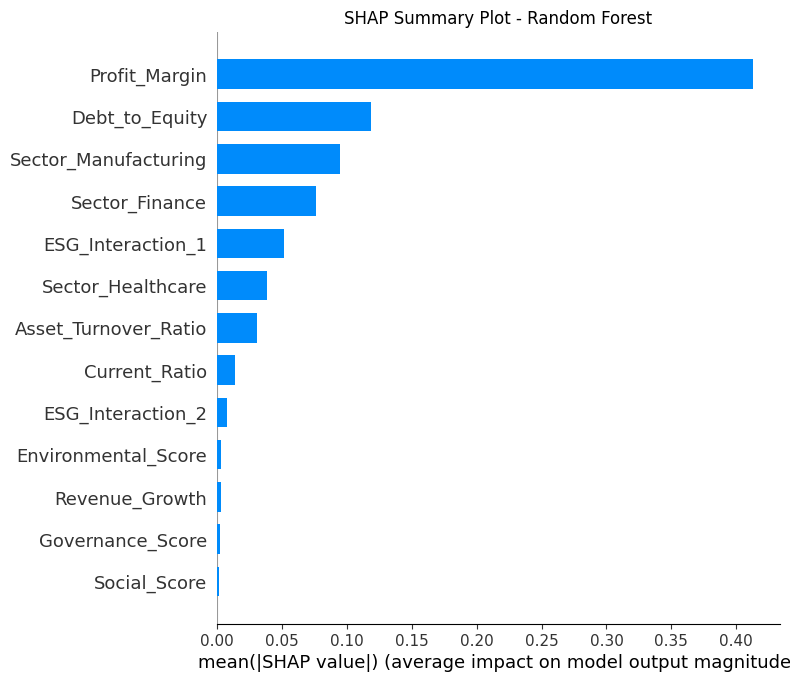

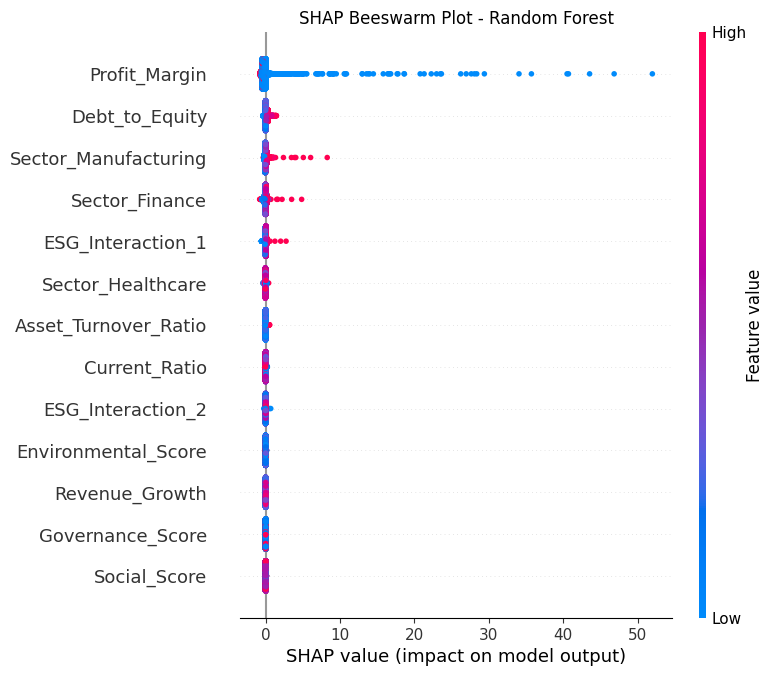

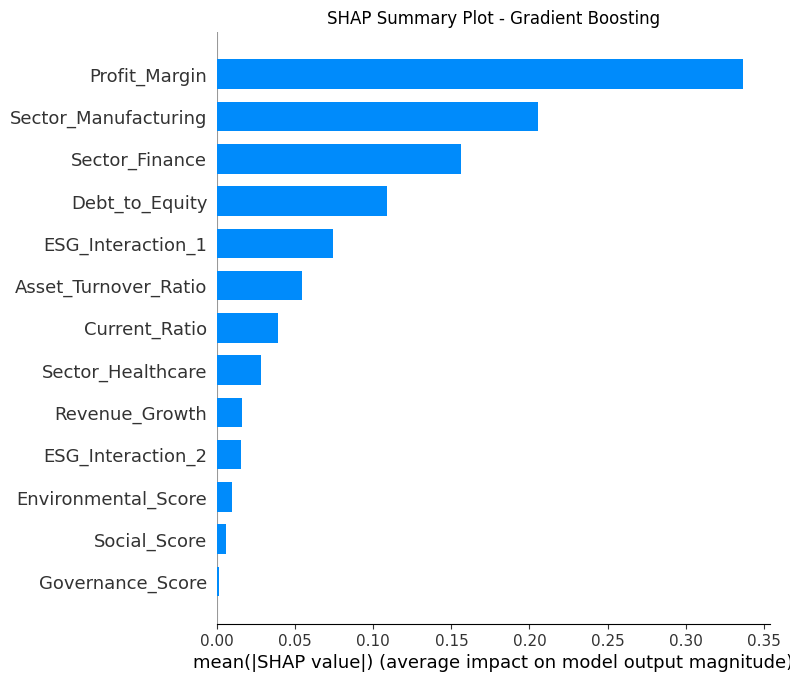

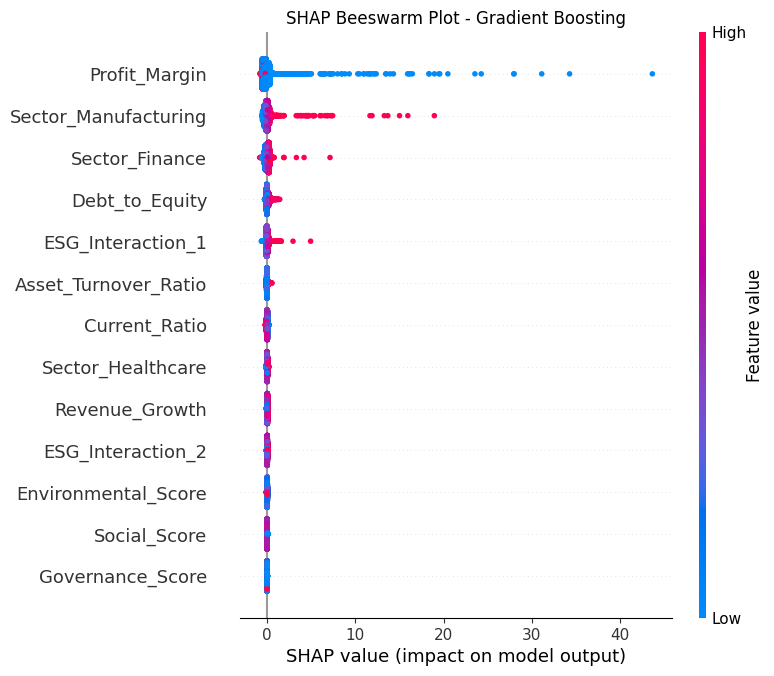

Shape of X_test: (10200, 13)
Number of features expected: 18
Features: ['Revenue_Growth', 'Profit_Margin', 'Debt_to_Equity', 'Current_Ratio', 'Asset_Turnover_Ratio', 'Environmental_Score', 'Social_Score', 'Governance_Score', 'ESG_Interaction_1', 'ESG_Interaction_2', 'Sector_Finance', 'Sector_Healthcare', 'Sector_Manufacturing', 'Sector_Services', 'Sector_Technology', 'Company_Size_Large', 'Company_Size_Medium', 'Company_Size_Small']


In [29]:
# SHAP analysis for Random Forest Regressor using best_rf_model
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# SHAP summary plots for the Random Forest model
shap.summary_plot(shap_values_rf, X_test, plot_type='bar', show=False)
plt.title('SHAP Summary Plot - Random Forest')
plt.show()

shap.summary_plot(shap_values_rf, X_test, show=False)
plt.title('SHAP Beeswarm Plot - Random Forest')
plt.show()

# SHAP analysis for Gradient Boosting Regressor using best_gb_model
explainer_gb = shap.TreeExplainer(gb_model)
shap_values_gb = explainer_gb.shap_values(X_test)

# SHAP summary plots for the Gradient Boosting model
shap.summary_plot(shap_values_gb, X_test, plot_type='bar', show=False)
plt.title('SHAP Summary Plot - Gradient Boosting')
plt.show()

shap.summary_plot(shap_values_gb, X_test, show=False)
plt.title('SHAP Beeswarm Plot - Gradient Boosting')
plt.show()

# Checking the shape of X_test and ensuring consistency with the feature list
print(f"Shape of X_test: {X_test.shape}")
print(f"Number of features expected: {len(features)}")
print("Features:", features)

# Ensuring that X_test columns contain the actual feature names
if isinstance(X_test, np.ndarray):
    if len(features) == X_test.shape[1]:
        X_test = pd.DataFrame(X_test, columns=features)
    else:
        raise ValueError(f"Mismatch in the number of features. X_test has {X_test.shape[1]} columns, "
                         f"but the features list contains {len(features)} items.")


For each of the XGBoost, CatBoost, and LightGBM models, the code retrieves the SHAP values computed on the test dataset (
X_test
), calls the
get_top_features
 function with the SHAP values and
pca_feature_names
, and prints the top features for each model.

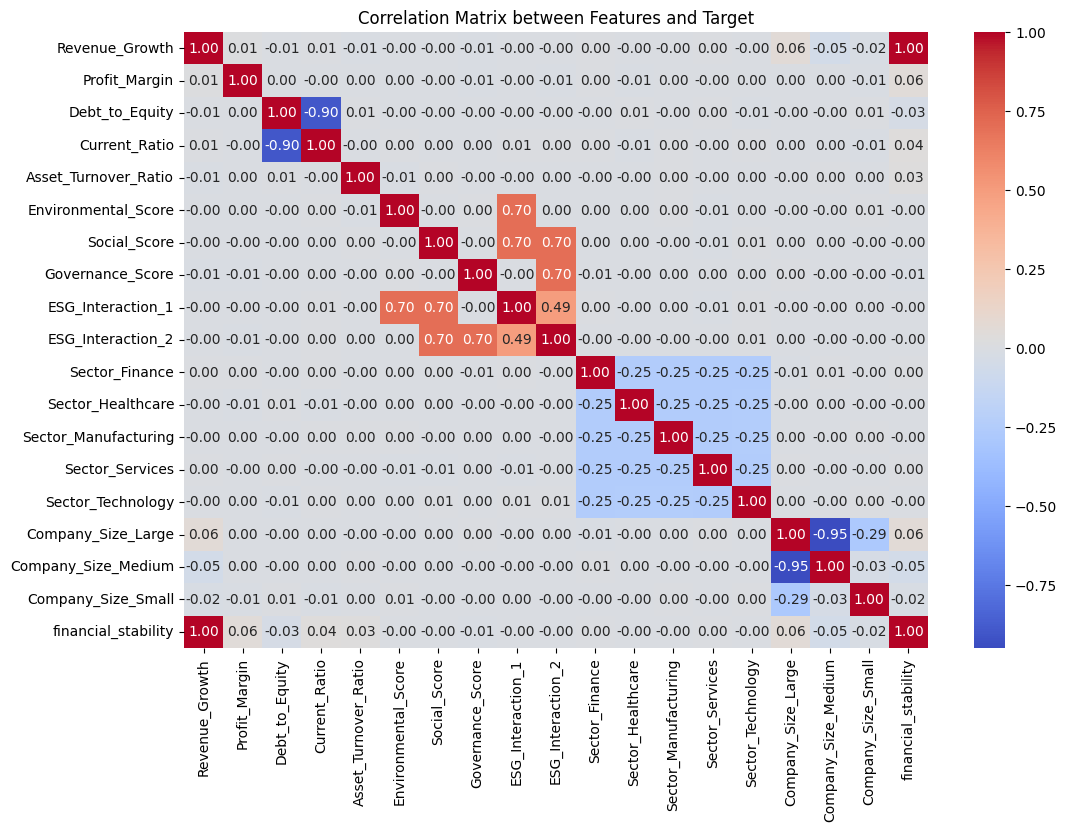

In [30]:
# Correlation Analysis
correlation_matrix = df[features + ['financial_stability']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix between Features and Target')
plt.show()

In [31]:
# Creating feature names for PCA components
pca_feature_names = ['PC' + str(i) for i in range(pca.n_components_)]

# Function to determine top features from SHAP values
def get_top_features(shap_values, feature_names, top_n=10):
    shap_df = pd.DataFrame(shap_values, columns=feature_names)
    top_features = shap_df.abs().mean().sort_values(ascending=False).head(top_n).index.tolist()
    return top_features

# Random Forest model
shap_values_rf = explainer_rf.shap_values(X_test)
top_features_rf = get_top_features(shap_values_rf, pca_feature_names)
print(f"Top features for Random Forest: {', '.join(top_features_rf)}")

# Gradient Boosting model
shap_values_gb = explainer_gb.shap_values(X_test)
top_features_gb = get_top_features(shap_values_gb, pca_feature_names)
print(f"Top features for Gradient Boosting: {', '.join(top_features_gb)}")

# XGBoost model
shap_values_xgb = explainer_xgb.shap_values(X_test)
top_features_xgb = get_top_features(shap_values_xgb, pca_feature_names)
print(f"Top features for XGBoost: {', '.join(top_features_xgb)}")

# CatBoost model
# Converting X_test column names to numerical indices for CatBoost SHAP values calculation
X_test_numeric = X_test.copy()
X_test_numeric.columns = range(X_test_numeric.shape[1])

# Using X_test_numeric for SHAP analysis with CatBoost
explainer_cat = shap.Explainer(cat_model)
shap_values_cat = explainer_cat.shap_values(X_test_numeric)
top_features_cat = get_top_features(shap_values_cat, pca_feature_names)
print(f"Top features for CatBoost: {', '.join(top_features_cat)}")

# LightGBM model
shap_values_lgb = explainer_lgb(X_test).values  # Extracting SHAP values from the Explanation object
top_features_lgb = get_top_features(shap_values_lgb, pca_feature_names)
print(f"Top features for LightGBM: {', '.join(top_features_lgb)}")


Top features for Random Forest: PC1, PC2, PC12, PC10, PC8, PC11, PC4, PC3, PC9, PC5
Top features for Gradient Boosting: PC1, PC12, PC10, PC2, PC8, PC4, PC3, PC11, PC0, PC9
Top features for XGBoost: PC4, PC1, PC12, PC10, PC6, PC5, PC7, PC8, PC2, PC3
Top features for CatBoost: PC1, PC12, PC10, PC4, PC2, PC8, PC6, PC11, PC3, PC5
Top features for LightGBM: PC1, PC12, PC10, PC4, PC2, PC8, PC5, PC3, PC11, PC9


Feature Loadings Analysis

In [32]:
# Get the top principal components (PCs) identified by SHAP for each model
top_pcs_rf = top_features_rf
top_pcs_gb = top_features_gb
top_pcs_xgb = top_features_xgb
top_pcs_cat = top_features_cat
top_pcs_lgb = top_features_lgb


# Combine all top PCs
combined_top_pcs = list(set(top_pcs_xgb + top_pcs_cat + top_pcs_lgb))

# Get the PCA components (loadings)
pca_components = pca.components_

# Creating a dataframe for PCA loadings
loadings = pd.DataFrame(pca_components.T, columns=pca_feature_names, index=features)

# Getting the loadings for the combined top PCs
top_loadings = loadings[combined_top_pcs]
print("Top Loadings for Combined Top PCs:")
print(top_loadings)

# To find the most influential original features for each top PC
num_top_features = 5  # Number of top original features to consider per PC

for pc in combined_top_pcs:
    print(f"\nTop {num_top_features} original features contributing to {pc}:")
    print(top_loadings[pc].abs().sort_values(ascending=False).head(num_top_features))


Top Loadings for Combined Top PCs:
                           PC2       PC7       PC6       PC8       PC3  \
Revenue_Growth       -0.006891  0.001649 -0.000705  0.261414 -0.005726   
Profit_Margin         0.001134  0.012941  0.021336  0.364546 -0.013806   
Debt_to_Equity        0.706430  0.008717  0.011891  0.005002 -0.005848   
Current_Ratio        -0.706463 -0.011051 -0.010441 -0.006934  0.005389   
Asset_Turnover_Ratio  0.007088  0.000507  0.014527  0.092422  0.007884   
Environmental_Score  -0.003754 -0.010290  0.002753 -0.178887 -0.574260   
Social_Score          0.011566  0.002266 -0.009081  0.182566 -0.000618   
Governance_Score      0.004981 -0.011314  0.014844 -0.184379  0.577851   
ESG_Interaction_1     0.004831 -0.005278 -0.003277  0.002693 -0.407598   
ESG_Interaction_2     0.011675 -0.005940  0.003971 -0.001141  0.409742   
Sector_Finance       -0.005687 -0.125506  0.061853 -0.025316 -0.022788   
Sector_Healthcare     0.016370 -0.279944 -0.733610  0.004241  0.000387   
Sec

Phase 5: FastAPI implementation

In [33]:
# Policy Implications
policy_text = """
## Policy Implications:
1. Investor Decision-Making: Encourage the adoption of predictive models that incorporate ESG scores and financial metrics to enhance investment decisions by accurately predicting financial stability.
2. Corporate Scenario Planning: Advocate for companies to use predictive models for evaluating financial stability under different scenarios, promoting data-driven strategic adjustments.
3. Management Strategy Enhancement: Recommend that company management integrate predictive models into their strategic planning processes to better identify potential risks and opportunities, improving overall financial predictions.
4. ESG Integration: Support policies that incentivize companies to improve their ESG scores, recognizing the direct impact of ESG factors on financial stability predictions.

"""

display(Markdown(policy_text))


## Policy Implications:
1. Investor Decision-Making: Encourage the adoption of predictive models that incorporate ESG scores and financial metrics to enhance investment decisions by accurately predicting financial stability.
2. Corporate Scenario Planning: Advocate for companies to use predictive models for evaluating financial stability under different scenarios, promoting data-driven strategic adjustments.
3. Management Strategy Enhancement: Recommend that company management integrate predictive models into their strategic planning processes to better identify potential risks and opportunities, improving overall financial predictions.
4. ESG Integration: Support policies that incentivize companies to improve their ESG scores, recognizing the direct impact of ESG factors on financial stability predictions.



In [34]:
import os

os.makedirs('models', exist_ok=True)


In [35]:
import joblib

# Saving the Random Forest model
joblib.dump(rf_model, 'models/random_forest_model.pkl')

# Saving the Gradient Boosting model
joblib.dump(gb_model, 'models/gradient_boosting_model.pkl')

# Saving the Optimized XGBoost model
joblib.dump(xgb_model, 'models/xgboost_model.pkl')

# Saving the Optimized CatBoost model
joblib.dump(cat_model, 'models/catboost_model.pkl')

# Saving the Optimized LightGBM model
joblib.dump(lgb_model, 'models/lightgbm_model.pkl')

print("Models have been saved successfully.")

Models have been saved successfully.


In [36]:
# Load your models
rf_model = joblib.load('/content/models/random_forest_model.pkl')
gb_model = joblib.load('/content/models/gradient_boosting_model.pkl')
xgb_model = joblib.load('/content/models/xgboost_model.pkl')
cat_model = joblib.load('/content/models/catboost_model.pkl')
lgb_model = joblib.load('/content/models/lightgbm_model.pkl')

print("Models loaded successfully!")


Models loaded successfully!


In [37]:
from pyngrok import ngrok

ngrok.set_auth_token("2kTcWWRDU68ekT9CPV6ggrUbkwV_5kZPzGCzqb8tZC32t1mAt") # run this, this should set your auth token

In [ ]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import Optional
import uvicorn
import nest_asyncio


cat_model = joblib.load('/content/models/catboost_model.pkl')
rf_model = joblib.load('/content/models/random_forest_model.pkl')
gb_model = joblib.load('/content/models/gradient_boosting_model.pkl')
xgb_model = joblib.load('/content/models/xgboost_model.pkl')
lgb_model = joblib.load('/content/models/lightgbm_model.pkl')

app = FastAPI()

class ESGInput(BaseModel):
    Revenue_Growth: float
    Profit_Margin: float
    Debt_to_Equity: float
    Current_Ratio: float
    Asset_Turnover_Ratio: float
    Environmental_Score: float
    Social_Score: float
    Governance_Score: float
    ESG_Interaction_1: float
    ESG_Interaction_2: float
    Sector_Finance: float
    Sector_Healthcare: float
    Sector_Manufacturing: float
    Sector_Services: Optional[float] = 0.0
    Sector_Technology: Optional[float] = 0.0
    Company_Size_Large: Optional[float] = 0.0
    Company_Size_Medium: Optional[float] = 0.0
    Company_Size_Small: Optional[float] = 0.0

class ESGOutput(BaseModel):
    model: str
    prediction: float

def predict_with_model(model, data):
    try:
        input_data = np.array([[
            data.Revenue_Growth,
            data.Profit_Margin,
            data.Debt_to_Equity,
            data.Current_Ratio,
            data.Asset_Turnover_Ratio,
            data.Environmental_Score,
            data.Social_Score,
            data.Governance_Score,
            data.ESG_Interaction_1,
            data.ESG_Interaction_2,
            data.Sector_Finance,
            data.Sector_Healthcare,
            data.Sector_Manufacturing
        ]])

        prediction = model.predict(input_data)
        return prediction[0]
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

# Endpoint for CatBoost model
@app.post("/predict/catboost", response_model=ESGOutput)
def predict_cat(data: ESGInput):
    prediction = predict_with_model(cat_model, data)
    return ESGOutput(model="CatBoost", prediction=prediction)

# Endpoint for Random Forest model
@app.post("/predict/random_forest", response_model=ESGOutput)
def predict_rf(data: ESGInput):
    prediction = predict_with_model(rf_model, data)
    return ESGOutput(model="Random Forest", prediction=prediction)

# Endpoint for Gradient Boosting model
@app.post("/predict/gradient_boosting", response_model=ESGOutput)
def predict_gb(data: ESGInput):
    prediction = predict_with_model(gb_model, data)
    return ESGOutput(model="Gradient Boosting", prediction=prediction)

# Endpoint for XGBoost model
@app.post("/predict/xgboost", response_model=ESGOutput)
def predict_xgb(data: ESGInput):
    prediction = predict_with_model(xgb_model, data)
    return ESGOutput(model="XGBoost", prediction=prediction)

# Endpoint for LightGBM model
@app.post("/predict/lightgbm", response_model=ESGOutput)
def predict_lgb(data: ESGInput):
    prediction = predict_with_model(lgb_model, data)
    return ESGOutput(model="LightGBM", prediction=prediction)

def run_app():
    nest_asyncio.apply()

    public_url = ngrok.connect(8000)
    print(f"Public URL: {public_url}")

    uvicorn.run(app, host="0.0.0.0", port=8000)

run_app()


INFO:     Started server process [112065]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Public URL: NgrokTunnel: "https://ff66-104-196-106-202.ngrok-free.app" -> "http://localhost:8000"
